# Clickabit detection using informativeness measures

## Packages

In [1]:
import warnings
import unicodedata
import string 

import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import textstat
from lexical_diversity import lex_div

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import math
import re
from tqdm import tqdm

from textblob import TextBlob
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

from tabulate import tabulate
from statsmodels.stats.weightstats import ttest_ind

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /home/tymek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
MODEL = Word2Vec.load("../pretrained_models/custom_word2vec.model")
STOP_WORDS = stopwords.words("english")

In [ ]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
pd.set_option('display.max_colwidth', 50)

## Preprocessing

In [410]:
raw_data = pd.read_csv("../data/cc_dataset_balanced.csv")
huge_data_raw = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [411]:
# drop NA
raw_data = raw_data.drop(raw_data[raw_data['body'].isna()].index)
raw_data = raw_data.drop_duplicates(['title'])
full_data = raw_data.copy()

In [412]:
# clean escape characters
full_data['body'] = full_data['body'].apply(lambda x: unicodedata.normalize('NFKC', x))
full_data['title'] = full_data['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

In [413]:
# universal split across notebooks
h_train, h_test = train_test_split(
    huge_data_raw[["title", "clickbait", "set"]], 
    test_size=0.2, 
    random_state=42
)

In [414]:
# get data only for clickbait challenge dataset
test_3 = h_test[h_test['set']==3].copy()
test_3['title'] = test_3['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

In [415]:
h_test

,title,clickbait,set
32823,31 Accessories Every ’90s Girl Will Recognize,1,3
16298,Drunken passenger triggers UK-Dominican Republ...,0,1
28505,"19 Confessions From People Who Are ""Defining T...",1,1
6689,'The Walking Dead' recap: Rick makes a new bes...,0,2
26893,Football Vs. Wife: Which Do You Know Better,1,1
...,...,...,...
13618,"In First Ban On Top Officials, Trump Administr...",0,2
35165,A Dating Site For Disney Fans Exists Because M...,1,1
16359,An Overseer of Medical Trials Comes Under Fire,0,1
3842,"A Debt Collector Is Killed In China, Triggerin...",0,2


In [419]:
# this will be used only for testing
part_test_data = pd.merge(left=test_3, right=full_data, on=['title', 'clickbait'], how='inner')[['title', 'body', 'clickbait']]

# this can be used for both training and testing
test_merged = pd.merge(left=test_3, right=full_data, on=['title'], how='right') 
not_test_data = test_merged[test_merged['clickbait_x'].isna()][['title', 'body', 'clickbait_y']].rename({'clickbait_y': 'clickbait'}, axis=1)

assert len(part_test_data) + len(not_test_data) <= len(test_merged)

In [420]:
print('test:', part_test_data['clickbait'].value_counts(), "\n")
print('train:', not_test_data['clickbait'].value_counts())

test: clickbait
1    778
0    437
Name: count, dtype: int64 

train: clickbait
0    8873
1    8514
Name: count, dtype: int64


In [421]:
train_rows_count = 7500

transfer_0 = not_test_data[not_test_data['clickbait']==0].shape[0] - train_rows_count
transfer_1 = not_test_data[not_test_data['clickbait']==1].shape[0] - train_rows_count

transfer_rows_0 = not_test_data[not_test_data['clickbait']==0].sample(n=transfer_0, random_state=42)
transfer_rows_1 = not_test_data[not_test_data['clickbait']==1].sample(n=transfer_1, random_state=42)

test_data = pd.concat([part_test_data, transfer_rows_0, transfer_rows_1])
data = not_test_data.drop(transfer_rows_0.index).drop(transfer_rows_1.index)

In [423]:
data.to_csv("../data/inf_measures_data/data.csv", index=False)
test_data.to_csv("../data/inf_measures_data/test_data.csv", index=False)

## EDA

In [7]:
eda_df = data.copy()

### Punctuation

In [8]:
def count_punkt(text, punkt):
    return sum([1 for char in text if char == punkt])

for punkt in string.punctuation:
    eda_df[f'{punkt}_count'] = eda_df['title'].apply(lambda x: count_punkt(x, punkt))

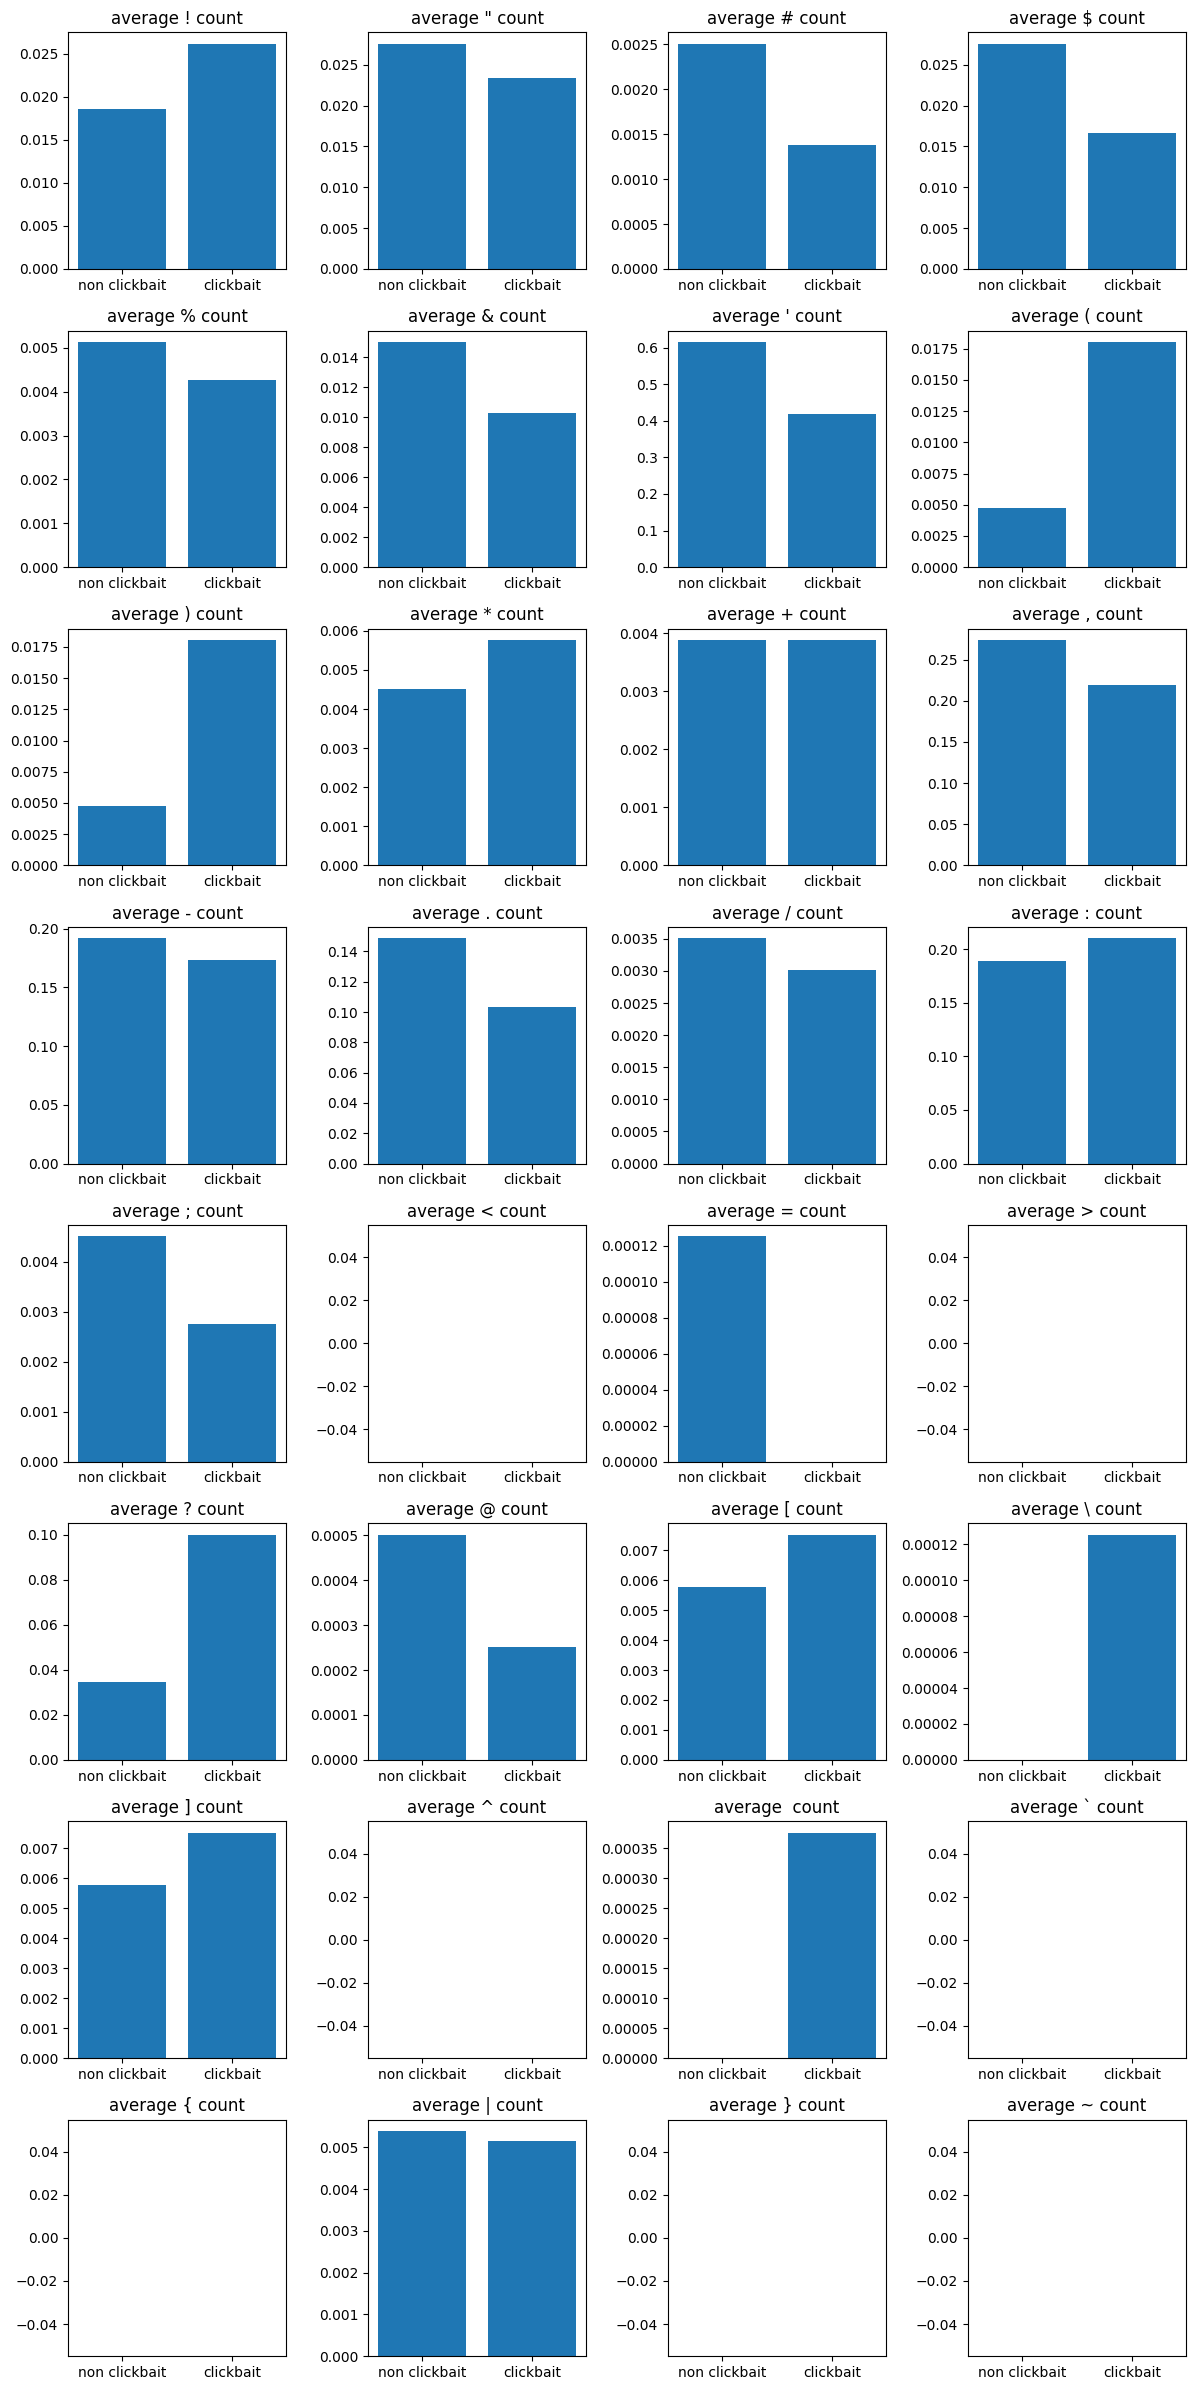

In [9]:
plt.figure(figsize=(12,24))
columns = eda_df.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(8, 4, i+1)
    n_mean = eda_df[eda_df['clickbait'] == 0][col].mean()
    c_mean = eda_df[eda_df['clickbait'] == 1][col].mean()
    plt.bar(['non clickbait', 'clickbait'], height=[n_mean, c_mean])
    plt.title(f"average {col.split('_')[0]} {col.split('_')[-1]}")
plt.tight_layout()
plt.show()

Based on those features we plan to build two measures - clickbait punctuation and non clickbait punctuation. We are taking into account only punctuation with average count over 0.001. <br>
<br>
clickbaits: !()*?[] <br>
non clickbaits: #$&';

### sth

## Embedding model

Training model for word embedding for similarity scores

In [ ]:
def preprocess_text(text):
    """ preprocess data for embedding model training """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

In [ ]:
df = data.copy()

In [ ]:
df['body_len'] = df['body'].apply(lambda x: len(x))
th = np.percentile(df['body_len'], 90)
df = df[df['body_len'] < th]

In [ ]:
df["title_tokens"] = df["title"].apply(preprocess_text)
df["body_tokens"] = df["body"].apply(preprocess_text)
df["combined_tokens"] = df["title_tokens"] + df["body_tokens"]
sentences = df["combined_tokens"].tolist()

In [ ]:
model = Word2Vec(sentences, vector_size=100, min_count=1, workers=4)

In [ ]:
model.save("../pretrained_models/custom_word2vec.model")

## Metrics definition

Defining informativeness measures

In [7]:
""" helper functions """

def remove_punctuation(text):
    """ removes punctuation """
    return text.translate(str.maketrans('', '', string.punctuation))

def preprocess_text(text):
    """ preprocess data for embedding model training """
    if isinstance(text, list):
        text = ' '.join(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

def get_embedding(sentence):
    """ gets embeddings """
    word_embeddings = [MODEL.wv[word] for word in sentence if word in MODEL.wv]
    if not word_embeddings: 
        return np.zeros(MODEL.vector_size)
    sentence_embedding = np.mean(word_embeddings, axis=0)
    return sentence_embedding

In [103]:
def words_count(text):
    """ calculates number of words """
    return len(text.split())

def characters_count(text):
    """ calculates number of characters including whitespaces """
    return len(text.strip())

def avg_word_length(text):
    """ calculates average word length """
    return float(np.mean([len(word) for word in word_tokenize(remove_punctuation(text))]))

def common_words_ratio(text):
    """ percentage of stop words in text """
    words = word_tokenize(remove_punctuation(text.lower()))
    common_words = [word for word in words if word in STOP_WORDS]
    return len(common_words) / len(words)

def capital_letters_ratio(text):
    """ calculates capital letters ratio """
    return sum([char.isupper() for char in list(text)]) / len(text)

def capital_words_count(text):
    """ calculates capital words """
    return sum([1 for word in word_tokenize(text) if word.isupper() and len(word) > 1])

def punctuation_ratio(text):
    """ calculates punctuation ratio """
    return sum([1 for x in text if x in string.punctuation]) / len(text)

def clickbait_punctuation_count(text):
    """ counts clickbait related punctuation, only left brackets as otherwise they would be double calculated """
    uncommon_punctuation = "!(*?["
    return sum([1 for x in text if x in uncommon_punctuation])

def nonclickbait_punctuation_count(text):
    """ counts non-clickbait related punctuation """
    uncommon_punctuation = "#$&';"
    return sum([1 for x in text if x in uncommon_punctuation])

def numbers_count(text):
    """ calculates ratio of numbers (not digits) to words """
    text = remove_punctuation(text)
    return sum([x.isnumeric() for x in word_tokenize(text)])

def pronouns_count(text):
    """ pronouns usage """
    tagged = pos_tag(word_tokenize(text.lower()))
    return sum([1 for x in tagged if x[1] in ('PRP', 'PRP$', 'WP', 'WP$')])

def pronouns_2nd_person_count(text):
    """ 2nd person pronouns usage """
    second_person_pronouns = ["you", "your", "yours", "yourself", "yourselves"]
    return sum([1 for x in word_tokenize(text.lower()) if x in second_person_pronouns])

def superlatives_ratio(text):
    """ percentage of adjectives and adverbs which are in superlative form """
    tagged_words = pos_tag(word_tokenize(text.lower()))
    adj_adv_count = 0
    superlative_count = 0
    for _, tag in tagged_words:
        if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'):
            adj_adv_count += 1
            if tag in ('JJS', 'RBS'):  # if superlative
                superlative_count += 1
    if adj_adv_count == 0:
        return 0
    return superlative_count / adj_adv_count

def speculatives_count(text):
    """ usage of speculative forms """
    speculative_words = {
        "might", "may", "could", "can", "perhaps", "possibly", "probably", "maybe",
        "seems", "appears", "suggests", "indicates", "likely", "unlikely", "assume"
    }
    return sum([1 for x in word_tokenize(text.lower()) if x in speculative_words])

def baiting_words_count(text):
    """ number of baiting words used """
    bait_words = {"sexy", "nudes", "OMG", "TWEETS", "VIDEO"}
    return sum([1 for x in word_tokenize(text) if x in bait_words])

def similarity_score(title, body):
    """ custom word2vec model embeddings and cosine similarity """
    title_embedding = get_embedding(word_tokenize(title.lower()))
    body_embedding = get_embedding(preprocess_text(word_tokenize(body.lower())))
    return (1 - cosine(title_embedding, body_embedding))

def polarity_score(text):
    """ polarity score """
    return TextBlob(text).sentiment.polarity

def subjectivity_score(text):
    """ subjectivity score """
    return TextBlob(text).sentiment.subjectivity

def type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / len(words)

def corrected_type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / np.sqrt(2 * len(words))

def maas_index(text):
    """ lexical diversity index, the lower the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    n = len(words)
    if n == 1:
        return 0
    t = len(set(words))
    return (math.log(n) - math.log(t)) / (math.log(n) ** 2)

def hdd_metric(text):
    """ hypergeometric distribution D, lexical diversity, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    if len(words) < 42:
        message = f"The text is {len(words)} words long. HD-D metric is not defined for texts with less than 42 tokens."
        warnings.warn(message, UserWarning)
    return lex_div.hdd(words)

def flesch_reading_ease_score(text):
    """ difficulty of the text, if its easy to read or not, the higher the easier
    
    Formula:
    206.835 - 1.015 * (total words / total sentences) - 84.6 (total syllables / total words)

    Scores:
    -90.00  	Very easy to read. Easily understood by an average 11-year-old student.
    90.0-80.0	Easy to read. Conversational English for consumers.
    80.0-70.0	Fairly easy to read.
    70.0-60.0	Plain English. Easily understood by 13- to 15-year-old students.
    60.0-50.0	Fairly difficult to read.
    50.0-30.0	Difficult to read.
    30.0-10.0	Very difficult to read. Best understood by university graduates.
    10.0-   	Extremely difficult to read. Best understood by university graduates.
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_reading_ease(text)

def flesch_kincaid_grade_level(text):
    """ difficulty of the text, US grade level needed to understand the text quite easily, the higher the harder

    Formula:
    0.39 * (total words / total sentences) + 11.8(total syllables / total words) - 15.59

    can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_kincaid_grade(text)

def automated_readability_index(text):
    """ difficulty of the text, US grade level necessary to comprehend the text, the higher the harder

    Formula:
    4.71 * (characters / words) + 0.5 (words / sentences) - 21.43

    Scores:
    score | age | grade level
    1	5-6	    Kindergarten
    2	6-7	    First Grade
    3	7-8	    Second Grade
    4	8-9	    Third Grade
    5	9-10	Fourth Grade
    6	10-11	Fifth Grade
    7	11-12	Sixth Grade
    8	12-13	Seventh Grade
    9	13-14	Eighth Grade
    10	14-15	Ninth Grade
    11	15-16	Tenth Grade
    12	16-17	Eleventh Grade
    13	17-18	Twelfth Grade
    14	18-22	College student
    source: https://en.wikipedia.org/wiki/Automated_readability_index
    """
    return textstat.automated_readability_index(text)


In [104]:
metrics_functions = {
    "n_words": words_count,
    "n_characters": characters_count,
    "mean_word_length": avg_word_length,
    "cw_percentage": common_words_ratio,
    "capitals_ratio": capital_letters_ratio,
    "capitals_count":capital_words_count,
    "punct": punctuation_ratio,
    "bait_punct": clickbait_punctuation_count,
    "nonbait_punct": nonclickbait_punctuation_count,
    "numbers": numbers_count,
    "pronouns": pronouns_count,
    "2nd_pronouns": pronouns_2nd_person_count,
    "superlatives": superlatives_ratio,
    "speculatives": speculatives_count,
    "bait_words": baiting_words_count,
    "similarity": similarity_score,
    "polarity": polarity_score,
    "subjectivity": subjectivity_score,
    "ttr": type_token_ratio,
    "cttr": corrected_type_token_ratio,
    "mass_index": maas_index,
    "hdd": hdd_metric,
    "fres": flesch_reading_ease_score,
    "fkgl": flesch_kincaid_grade_level,
    "ari": automated_readability_index
}

In [105]:
""" test """

sample_text = "These 12 Most Impossible Pet Rescure Stories Will Melt Your Heart! [VIDEO]"

sample_body = """
Recently, we asked the BuzzFeed Community to tell us their pet adoption stories. Here are some of the sweetest, heartwarming, and most ~meant-to-be~ submissions:
1. From stray to service dog
"My younger brother — who lives with autism and Type 1 diabetes — has needed a service dog for a while now. So when my family met Ellie, a sweet, attentive rescue from Mexico, we instantly knew she was the right dog for my brother.
Right now, someone has to wake up every 2-3 hours at night to check my brother's blood sugar, and we have to constantly watch to make sure he doesn’t eat something without telling us. Once Ellie graduates her training, we'll all be able to sleep through the night and loosen the reigns on my brother during the day. It’s impossible to express how thankful we are that we found Ellie."
-maritnifa68
2. Brew-ser
"I was at a beer fest when I overheard this woman say, 'I’m just going to leave this dog on the street. I can’t take it anymore.' I had drank just enough beer to turn around and say, 'I’ll take your dog!'
12 years later, and here's my handsome boy, appropriately named Brew-ser!"
—megank29
"""

for key, f in metrics_functions.items():
    if key == 'similarity':
        continue
        print(f"{key}: {f(sample_text, sample_body)}")
        continue
    print(f"{key}: {f(sample_text)}")

n_words: 12
n_characters: 74
mean_word_length: 5.0
cw_percentage: 0.3333333333333333
capitals_ratio: 0.20270270270270271
capitals_count: 1
punct: 0.04054054054054054
bait_punct: 2
nonbait_punct: 0
numbers: 1
pronouns: 1
2nd_pronouns: 1
superlatives: 0.25
speculatives: 0
bait_words: 1
polarity: -0.16666666666666663
subjectivity: 0.75
ttr: 1.0
cttr: 2.4494897427831783
mass_index: 0.0
hdd: 0.0
fres: 76.22
fkgl: 5.6
ari: 9.3


/tmp/ipykernel_1113/1258563302.py:123: UserWarning: The text is 12 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)


## EDA & models

### Title analysis

#### Preprocessing

In [14]:
data_metrics = data.copy()

In [15]:
# apply metrics
for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        data_metrics[name] = data_metrics['title'].apply(function)

for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        test_data[name] = test_data['title'].apply(function)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>,
        <Axes: title={'center': 'mean_word_length'}>,
        <Axes: title={'center': 'cw_percentage'}>],
       [<Axes: title={'center': 'capitals_ratio'}>,
        <Axes: title={'center': 'capitals_count'}>,
        <Axes: title={'center': 'punct'}>,
        <Axes: title={'center': 'bait_punct'}>,
        <Axes: title={'center': 'nonbait_punct'}>],
       [<Axes: title={'center': 'numbers'}>,
        <Axes: title={'center': 'pronouns'}>,
        <Axes: title={'center': '2nd_pronouns'}>,
        <Axes: title={'center': 'superlatives'}>,
        <Axes: title={'center': 'speculatives'}>],
       [<Axes: title={'center': 'bait_words'}>,
        <Axes: title={'center': 'polarity'}>,
        <Axes: title={'center': 'subjectivity'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'ma

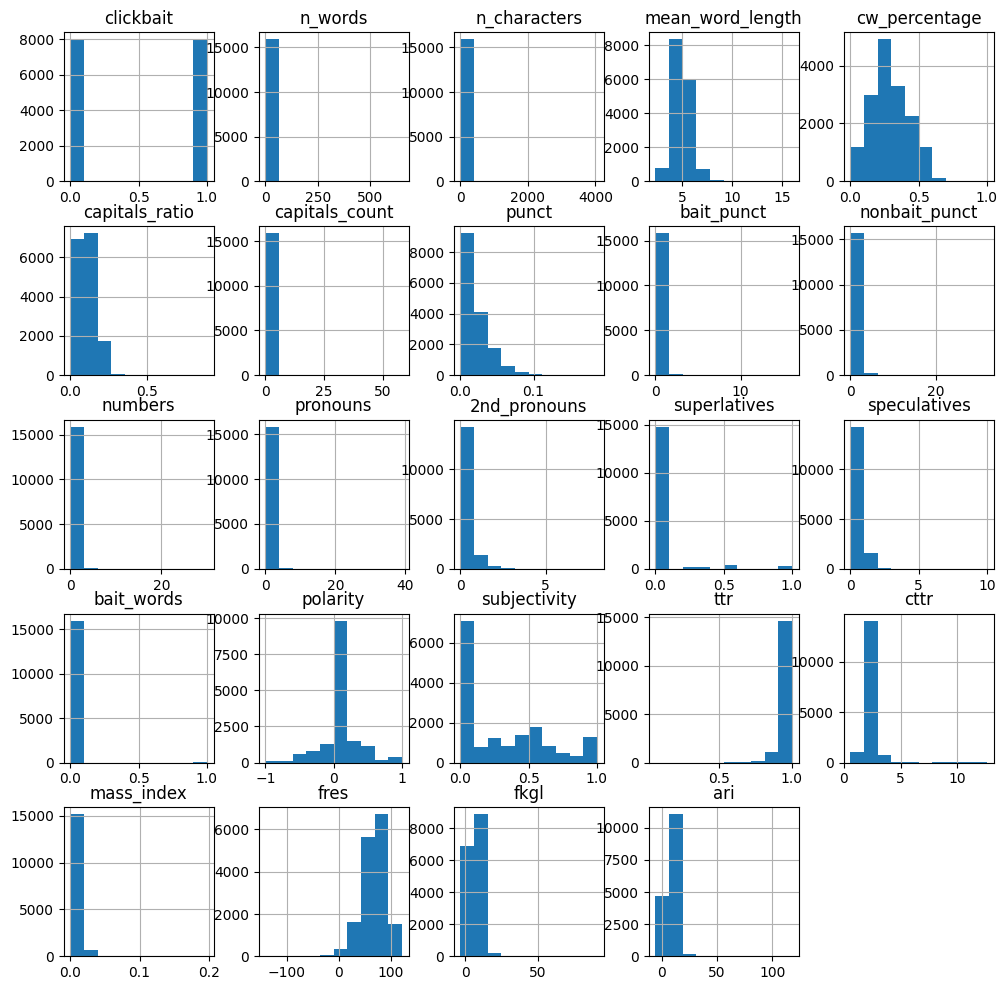

In [16]:
# check histograms
data_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Histograms for n_words and n_characters look bad. There are some outliers, possibly because of flaws in data scraping, for example:

In [17]:
# example of problematic title
long_titles = data_metrics[data_metrics['n_words'] > 100]
long_titles['title'].iloc[2]

"Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights reserved. ABC News Homer and Marge to Separate on 'The Simpsons' The Reason Why Homer and Marge Will Split on 'The Simpsons' Priyanka Chopra on starring in the 'quintessential American dream' Gillian Anderson reveals long struggle with mental health issues Tensions reach all-time high on 'The Walking Dead' 'Jersey Shore' stars reunite for Sammi's 30th birthday party Slain singer Christina Grimmie's family remembers her on 23rd birthday Stanley Tucci on his 'Beauty and the Beast' character, new role in 'Feud' 'Arrow' star Colton Haynes is engaged to Jeff Leatham 'What's a yoot?' 'My Cousin Vinny' turns 25 Criss Angel speaks out after losing consciousness in failed stunt Nick Viall might be first Bachelor 'to be left at the end' Trump was talking about general surveillance in wiretapping claims, Spicer says GOP congressman defends racially charged tweet against critics States seeking Trump travel

In [18]:
# mean
print(f"mean number of words: {round(np.mean(data_metrics['n_words']), 1)}\n")
# percentiles
q_percentiles = [90, 99, 99.5, 99.7]
percentiles = np.percentile(data_metrics['n_words'], q_percentiles)
print(f"Percentiles:\nq: {q_percentiles}\n{percentiles}")

mean number of words: 12.6

Percentiles:
q: [90, 99, 99.5, 99.7]
[ 16.     30.     36.24  224.584]


In [19]:
# clickbait / non-clickbait ratio
long_titles = data_metrics[data_metrics['n_words'] > 40]
print("", long_titles['clickbait'].value_counts())

 clickbait
0    36
1    33
Name: count, dtype: int64


Looking at the percentiles we can safely delete all titles longer than 40 words, also the ratio of target variable won't be disturbed

In [20]:
# dropping outliers
shortened_metrics = data_metrics[data_metrics['n_words'] <= 40].copy()

array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>]], dtype=object)

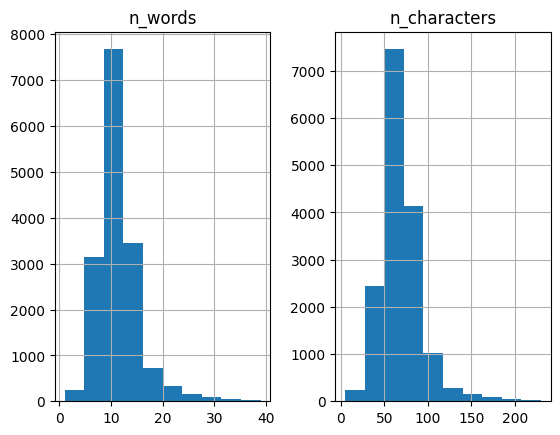

In [21]:
# check histograms again
shortened_metrics[['n_words', 'n_characters']].hist()

In [22]:
# lets check outliers for articles the same way

In [23]:
# apply metrics
name = 'n_words'
function = metrics_functions[name]
shortened_metrics[f"body_{name}"] = shortened_metrics['body'].apply(function)

<Axes: >

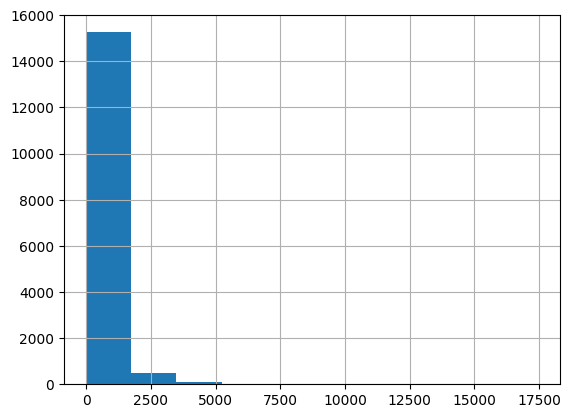

In [24]:
shortened_metrics['body_n_words'].hist()

In [45]:
len(shortened_metrics[shortened_metrics['body_n_words'] < 5000]) / len(shortened_metrics)

0.9964744396877361

In [46]:
# dropping outliers
pre_final_data = shortened_metrics[shortened_metrics['body_n_words'] <= 4000].copy()
final_data = pre_final_data.drop(["body_n_words"], axis=1)

#### Overview

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

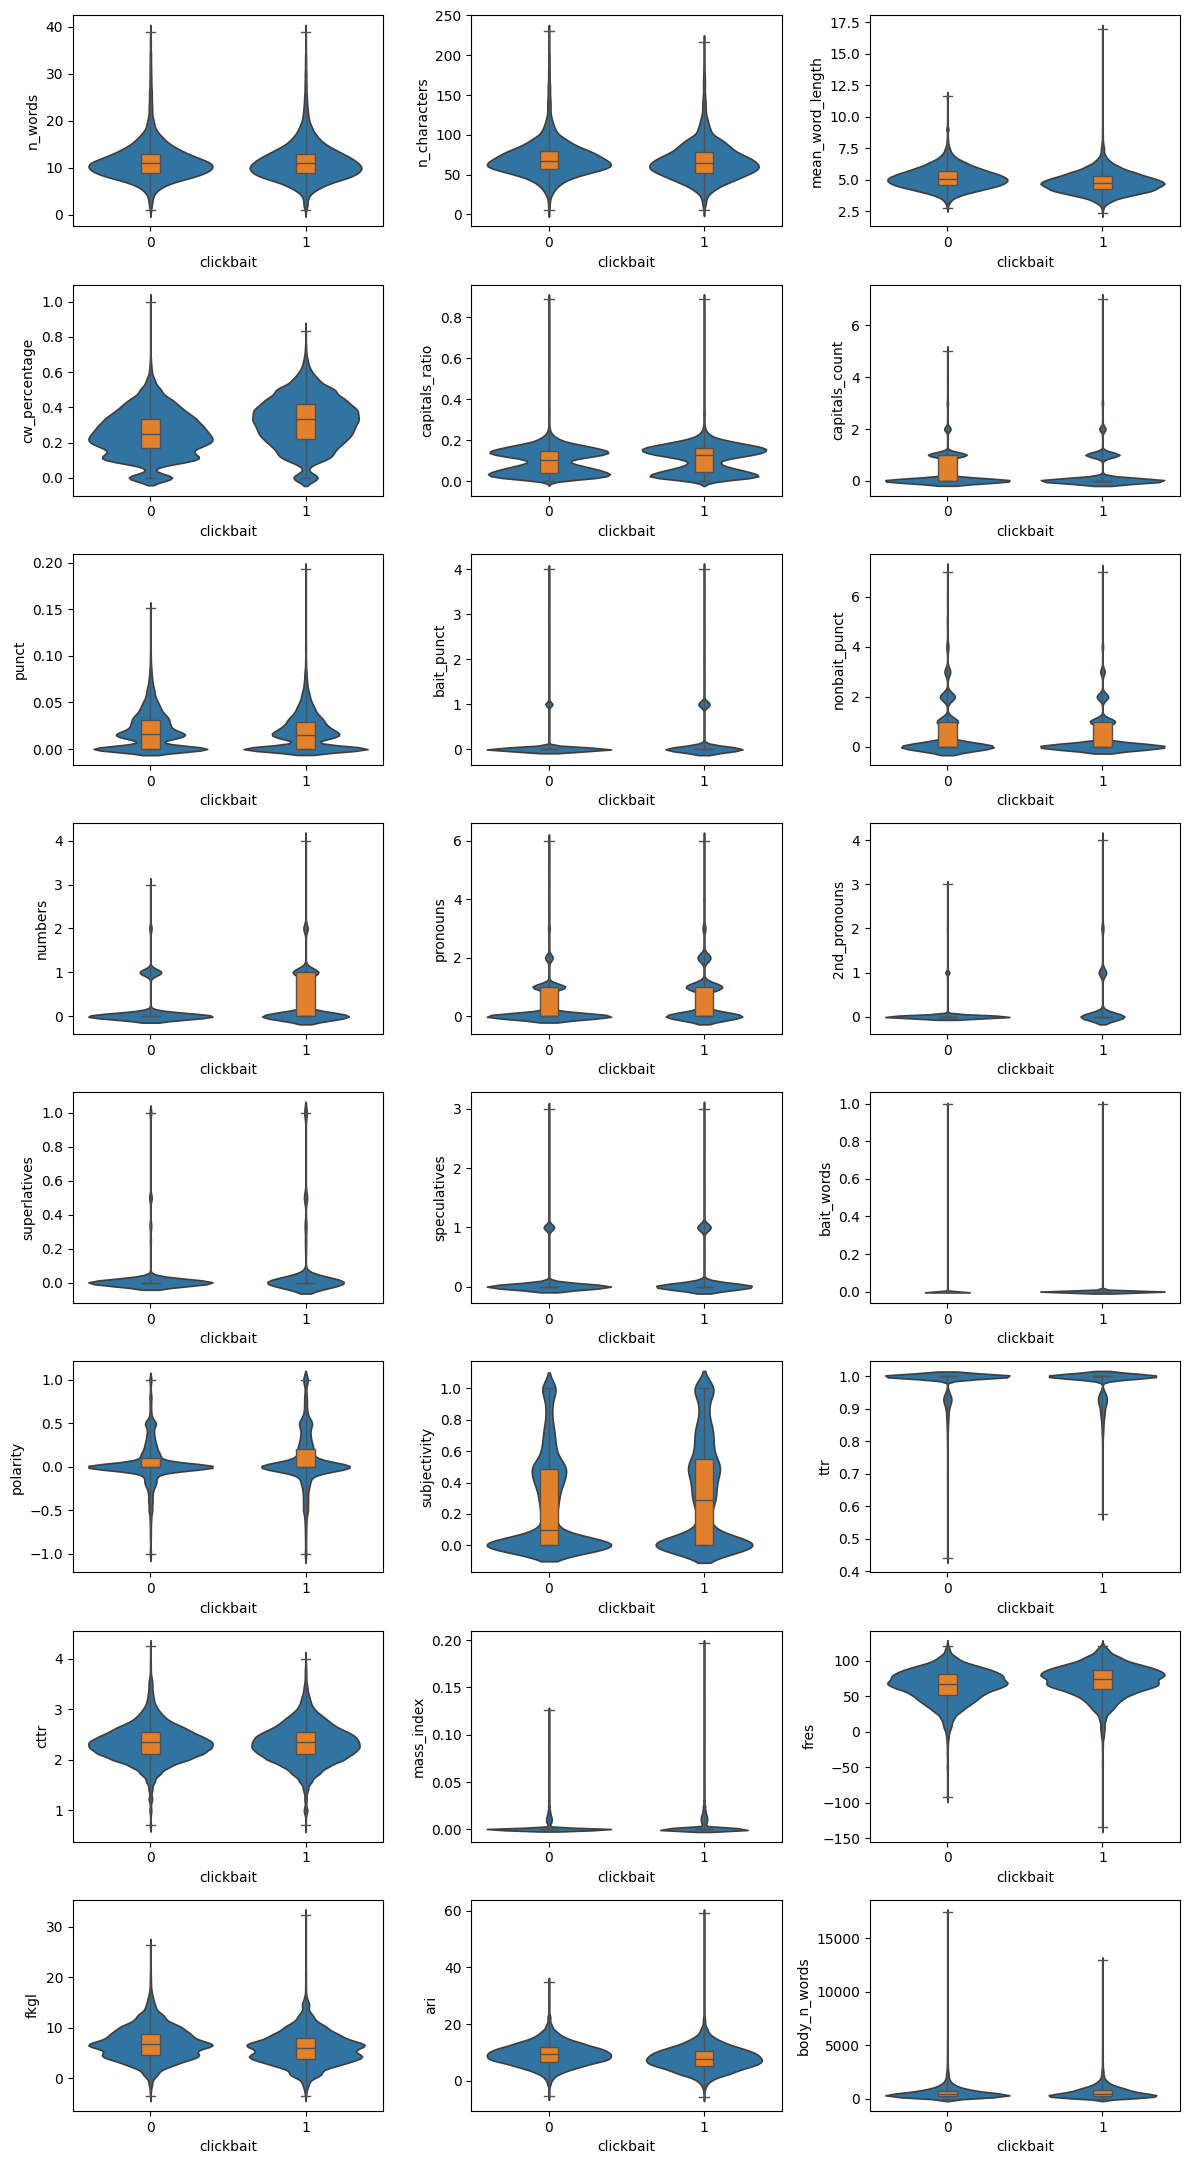

In [150]:
plt.figure(figsize=(12,24))
columns = final_data.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(9, 3, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=shortened_metrics, inner=None)
    sns.boxplot(x='clickbait', y=col, data=shortened_metrics, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

Half of the measures have almost identical characteristics for bait and non-bait. 

The only clear difference in median is in average percentage of common words, which is higher for clickbaits. There are also differences for other variables (capital letters, subjectivity, metrics measuring difficulty of the text) but they are rather not substantial

Many metrics have bigger standard deviation for clickbaits e.g., avg word length, punctuation usage, numbers or mass index.

#### Analysis

In [87]:
def print_metrics(data, column, round_val=2):

    data_0 = data[data['clickbait'] == 0][column]
    data_1 = data[data['clickbait'] == 1][column]

    vals_0 = data_0.describe()
    vals_1 = data_1.describe()

    vals_0.drop(['count', '25%', '75%'], inplace=True)
    vals_1.drop(['count', '25%', '75%'], inplace=True)

    vals_1.at['ratio'] = round(vals_1['mean'] / vals_0['mean'], 2)

    vals_0 = vals_0.apply(lambda x: round(x, round_val))
    vals_1 = vals_1.apply(lambda x: round(x, round_val))

    vals_0.at['ratio'] = ''

    vals_0.name = 'non clickbait'
    vals_1.name = 'clickbait'

    print(tabulate(pd.DataFrame([vals_0, vals_1]), headers=vals_1.index))

def plot_metrics(data, column):
    ax = sns.violinplot(x='clickbait', y=column, data=data, inner=None)
    sns.boxplot(x='clickbait', y=column, data=data, width=0.12, whis=(0, 100), ax=ax)

def print_merged(metric, on='title'):
    nonbait = " ".join(final_data[final_data['clickbait']==0][on].to_list())
    bait = " ".join(final_data[final_data['clickbait']==1][on].to_list())
    print(f"{metric.upper()}")
    print(f"non clickbait:  {round(metrics_functions[metric](nonbait), 3)}")
    print(f"clickbait:      {round(metrics_functions[metric](bait), 3)}")

##### Number of words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   11.45   4.19      1     11     39
clickbait       11.35   4.18      1     11     39  0.99


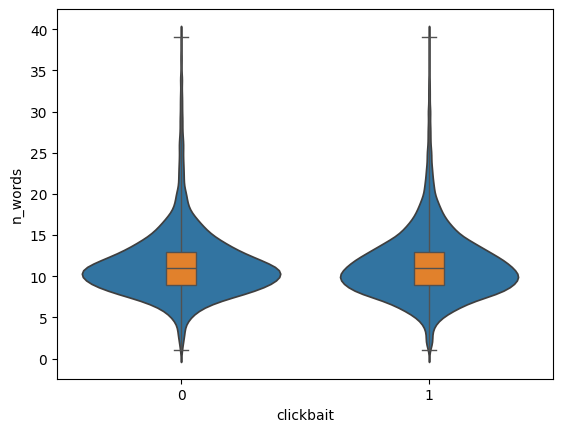

In [151]:
print_metrics(final_data, 'n_words')
plot_metrics(final_data, 'n_words')

In [93]:
# No difference at all for titles

##### Number of characters

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   70.57  24.03      5     67    230
clickbait       67.08  24.28      6     64    217  0.95


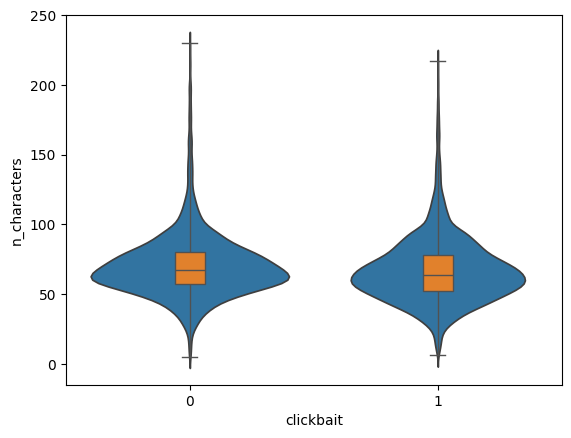

In [152]:
print_metrics(final_data, 'n_characters')
plot_metrics(final_data, 'n_characters')

In [ ]:
# same as before

##### Mean word length

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    5.15   0.88   2.75   5.08  11.67
clickbait        4.8    0.86   2.33   4.73  17     0.93


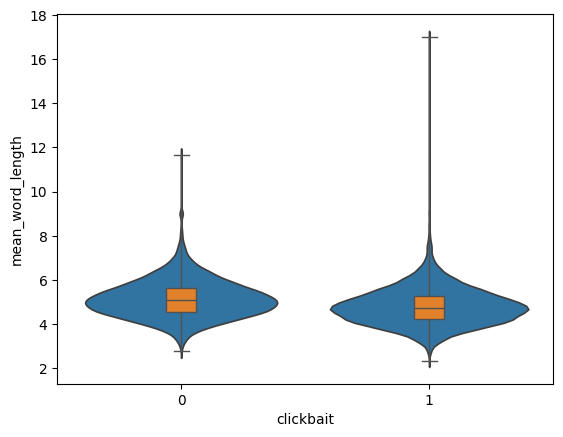

In [156]:
print_metrics(final_data, 'mean_word_length')
plot_metrics(final_data, 'mean_word_length')

In [172]:
# slightly shorter words on average for clickbaits

##### Common words percentage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.25   0.13      0   0.25   1
clickbait        0.32   0.14      0   0.33   0.83  1.28


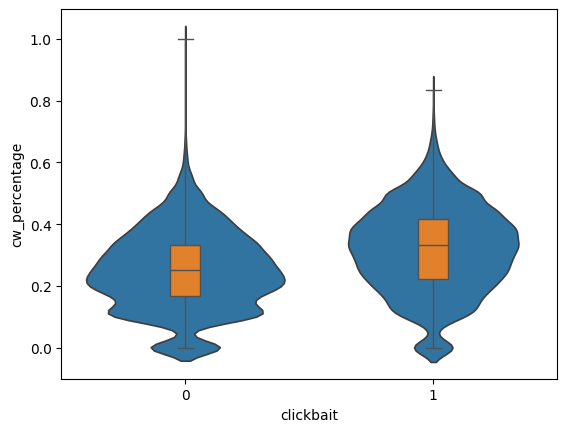

In [103]:
print_metrics(shortened_metrics, 'cw_percentage')
plot_metrics(shortened_metrics, 'cw_percentage')

In [104]:
# significant difference, clickbaits have more common words

##### Capital letters ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.1    0.06      0   0.1    0.89
clickbait        0.11   0.07      0   0.13   0.89  1.1


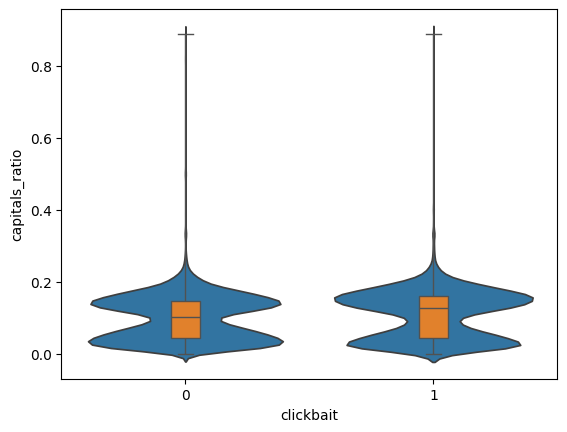

In [105]:
print_metrics(shortened_metrics, 'capitals_ratio')
plot_metrics(shortened_metrics, 'capitals_ratio')

In [177]:
# slightly bigger mean and median for clickbaits

##### Capital words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.31   0.58      0      0      5
clickbait        0.3    0.6       0      0      7  0.97


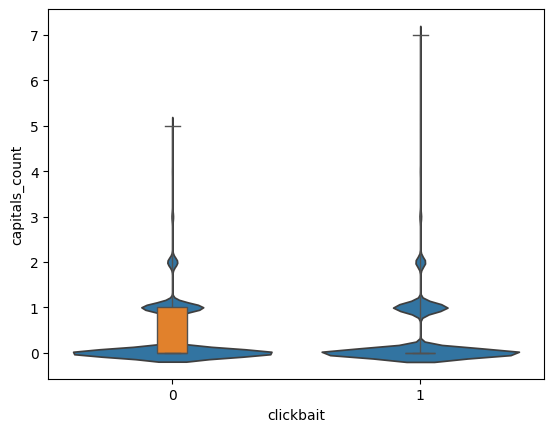

In [106]:
print_metrics(shortened_metrics, 'capitals_count')
plot_metrics(shortened_metrics, 'capitals_count')

In [107]:
# no difference

##### Punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.02   0.02      0   0.02   0.15
clickbait        0.02   0.02      0   0.02   0.19  1.0


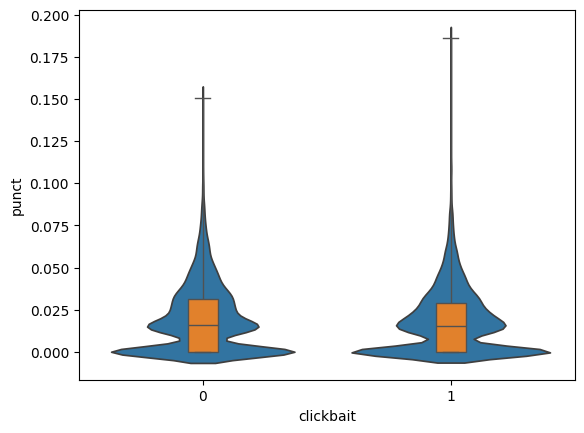

In [178]:
print_metrics(shortened_metrics, 'punct')
plot_metrics(shortened_metrics, 'punct')

In [109]:
# almost the same

##### Clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.06   0.26      0      0      4
clickbait        0.15   0.39      0      0      4  2.5


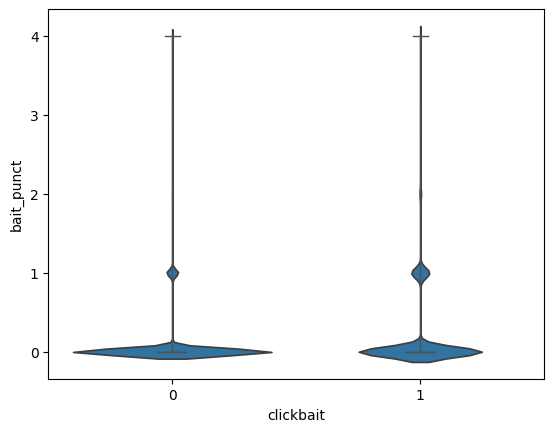

In [111]:
print_metrics(shortened_metrics, 'bait_punct')
plot_metrics(shortened_metrics, 'bait_punct')

In [112]:
# this feature was engineered based on eda, as we can see the mean count is way higher for clickbaits

##### Non clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.58   1.01      0      0      7
clickbait        0.4    0.81      0      0      7  0.69


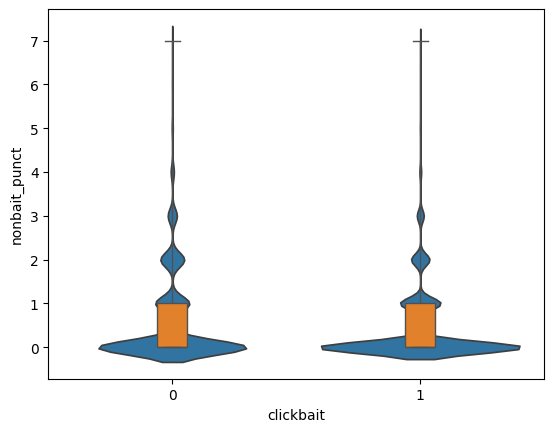

In [113]:
print_metrics(shortened_metrics, 'nonbait_punct')
plot_metrics(shortened_metrics, 'nonbait_punct')

In [114]:
# similar distribution, but mean count is higher for non clickbaits

##### Numbers usage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.18   0.43      0      0      3
clickbait        0.3    0.55      0      0      4  1.67


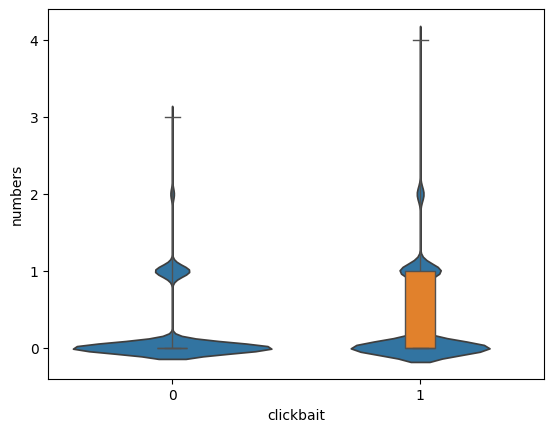

In [117]:
print_metrics(shortened_metrics, 'numbers')
plot_metrics(shortened_metrics, 'numbers')

In [118]:
# way more numbers used in clickbaits

##### Pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.33   0.64      0      0      6
clickbait        0.58   0.83      0      0      6  1.76


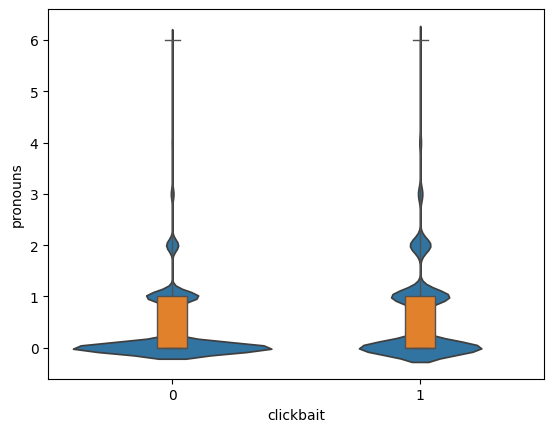

In [120]:
print_metrics(shortened_metrics, 'pronouns')
plot_metrics(shortened_metrics, 'pronouns')

In [121]:
# similar situation as before, median is 0 for both, but average usage is bigger for clickbaits

##### 2 person pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.04   0.21      0      0      3
clickbait        0.22   0.52      0      0      4  5.5


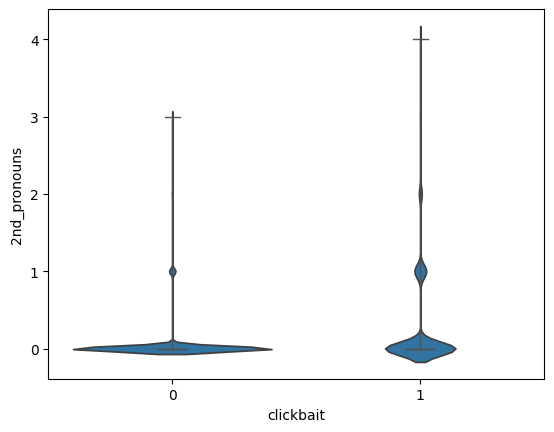

In [122]:
print_metrics(shortened_metrics, '2nd_pronouns')
plot_metrics(shortened_metrics, '2nd_pronouns')

In [ ]:
# here the difference is big, most non-bait titles do not use 2nd person pronouns

##### Superlatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.03   0.13      0      0      1
clickbait        0.06   0.19      0      0      1  2.0


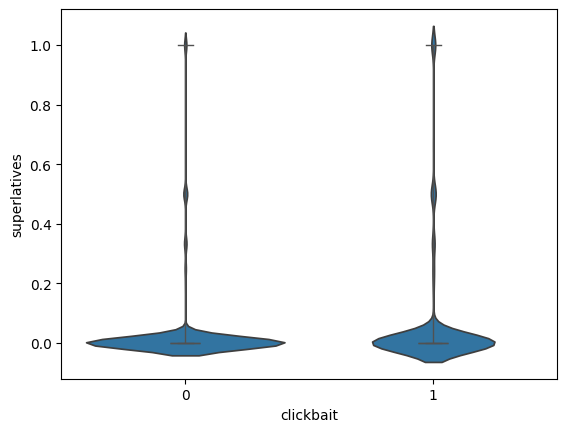

In [124]:
print_metrics(shortened_metrics, 'superlatives')
plot_metrics(shortened_metrics, 'superlatives')

In [125]:
# superlatives are used two times more in clickbaits, however they are still rare 

##### Speculatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.08   0.29      0      0      3
clickbait        0.13   0.35      0      0      3  1.62


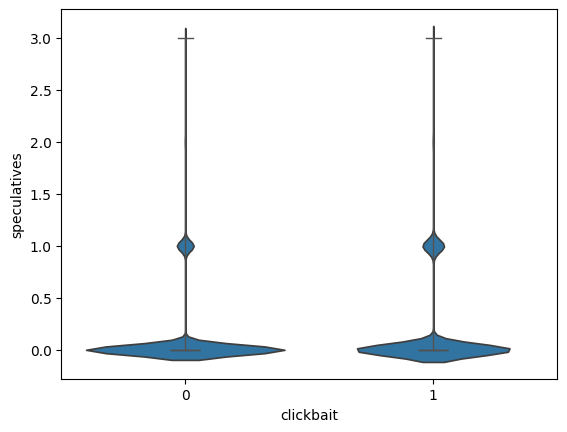

In [126]:
print_metrics(shortened_metrics, 'speculatives')
plot_metrics(shortened_metrics, 'speculatives')

In [128]:
# the same happens in here

##### Bait words

In [ ]:
# TODO

##### Polarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.04   0.24     -1      0      1
clickbait        0.08   0.31     -1      0      1  2.0


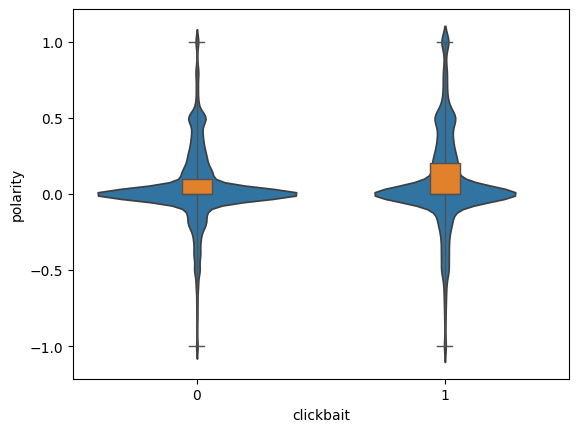

In [131]:
print_metrics(shortened_metrics, 'polarity')
plot_metrics(shortened_metrics, 'polarity')

In [ ]:
# polarity is more varied in clickbaits than in non clickbait headlines and, interestingly, more positive than negative on average

##### Subjectivity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.26   0.31      0   0.1       1
clickbait        0.32   0.33      0   0.29      1  1.23


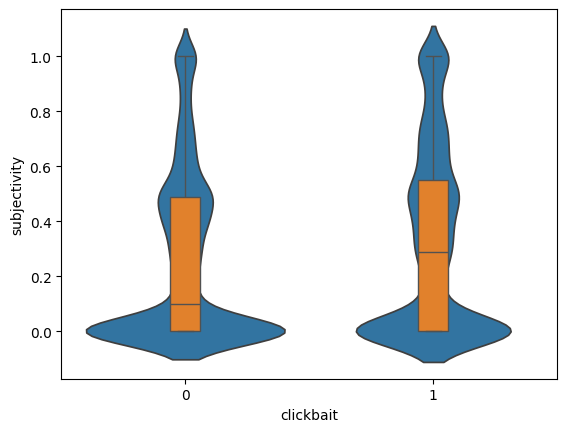

In [132]:
print_metrics(shortened_metrics, 'subjectivity')
plot_metrics(shortened_metrics, 'subjectivity')

In [ ]:
# clickbaits titles are more subjective. Both mean and median is bigger for clickbaits

##### TTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.98   0.04   0.44      1      1
clickbait        0.98   0.05   0.58      1      1  1.0


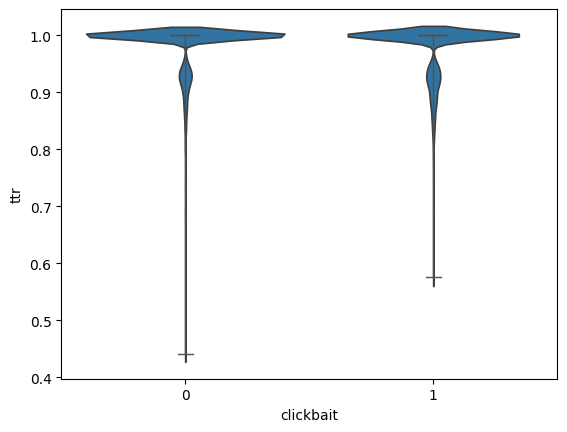

In [157]:
print_metrics(final_data, 'ttr')
plot_metrics(final_data, 'ttr')

In [199]:
# No difference at all, but its not strange as for most titles ttr will be 1, cause titles are so short its hard to not use all unique words
# lets check lexical diversity over all titles

In [202]:
print_merged('ttr')

TTR
non clickbait:  0.168
clickbait:      0.147


In [205]:
# clickbaits are less lexically diversed

##### CTTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    2.33   0.37   0.71   2.35   4.24
clickbait        2.32   0.39   0.71   2.35   4     1.0


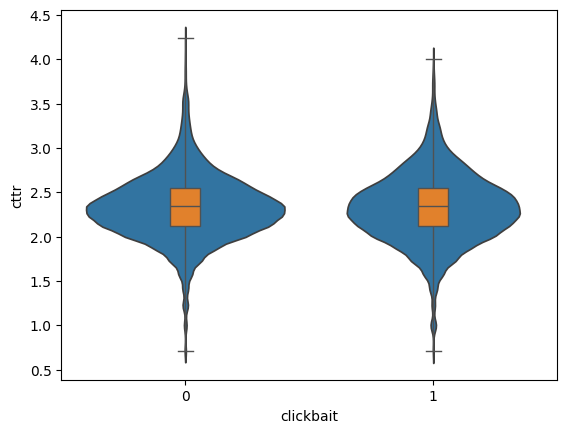

In [136]:
print_metrics(shortened_metrics, 'cttr')
plot_metrics(shortened_metrics, 'cttr')

In [137]:
# a little bigger standard deviation for cttr for clickbaits, other than that no differences

In [203]:
print_merged('cttr')

CTTR
non clickbait:  36.074
clickbait:      31.708


In [204]:
# again non clickbaits are more diversed

##### Maas index

/tmp/ipykernel_3018/1053143946.py:20: RuntimeWarning: invalid value encountered in scalar divide
  vals_1.at['ratio'] = round(vals_1['mean'] / vals_0['mean'], round_val)


                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait       0   0.01      0      0   0.13
clickbait           0   0.01      0      0   0.2   nan


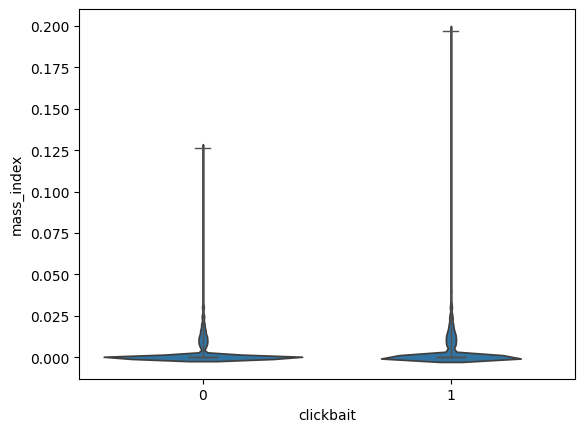

In [148]:
print_metrics(shortened_metrics, 'mass_index')
plot_metrics(shortened_metrics, 'mass_index')

In [206]:
# same issue as ttr

In [207]:
print_merged('mass_index')

MASS_INDEX
non clickbait:  0.014
clickbait:      0.015


In [208]:
# only small advantage for non clickbait headlines

##### FRES

                 mean    std     min    50%     max  ratio
-------------  ------  -----  ------  -----  ------  -------
non clickbait   65.02  22.97   -91.3  67.76  121.22
clickbait       71.67  22.21  -133.6  74.19  121.22  1.1


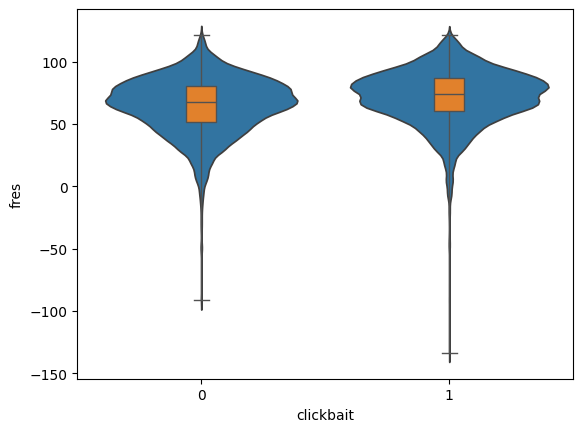

In [140]:
print_metrics(shortened_metrics, 'fres')
plot_metrics(shortened_metrics, 'fres')

In [141]:
# clickbaits headlines are easier to read

##### FKGL

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    6.93   3.32   -3.5    6.8   26.5
clickbait        5.95   3.25   -3.5    6     32.4  0.86


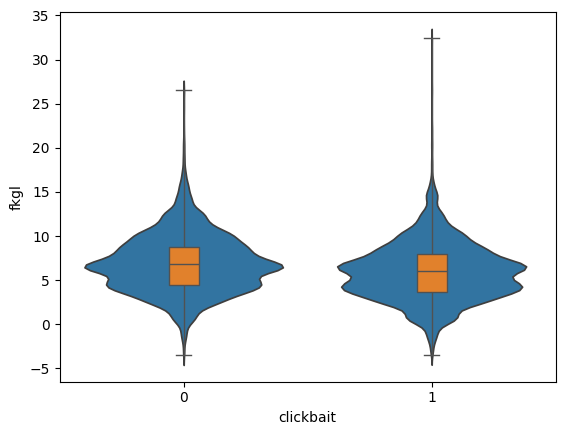

In [142]:
print_metrics(shortened_metrics, 'fkgl')
plot_metrics(shortened_metrics, 'fkgl')

In [143]:
# same results here, clickbait headlines are easier to read

##### ARI

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    9.43   3.98   -5.4    9.3   35
clickbait        7.99   4.13   -5.8    7.7   59.1  0.85


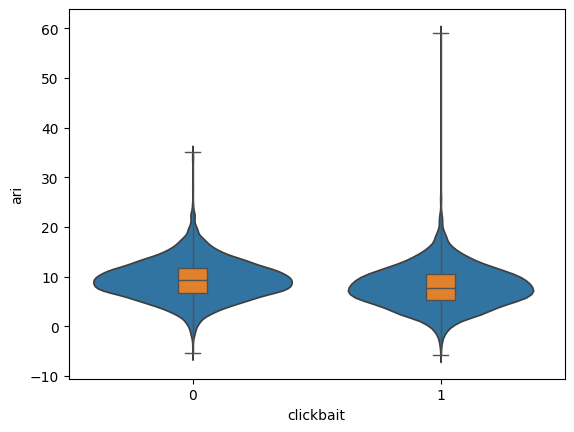

In [144]:
print_metrics(shortened_metrics, 'ari')
plot_metrics(shortened_metrics, 'ari')

In [ ]:
# distributions look similar to the fkgl

#### Summary

The differences are rather not substantial.

Clickbaits have smaller average word length (correlates with higher common words percentage), they are also easier to read. It is hard to calculate lexical diversity for titles, as they are super short. However, lexical diversity of all titles merged together is smaller for clickbaits. Clickbait headlines are also more subjective.

Measures prepared specifically for clickbaits are all higher for clickbait headlines (pronouns, superlatives, speculatives). What's more, numbers usage is also higher. 
Whats weird, there are no big differenes in capital letters usage.

Clickbaits often have higher standard deviation and more outliers.  

#### Fitting models:

Even if in the previous analysis for some features there were no differences between clickbaits and non-clickbaits, those features will still be included in the model building, as they may <i>interfere</i> with others.

<Axes: >

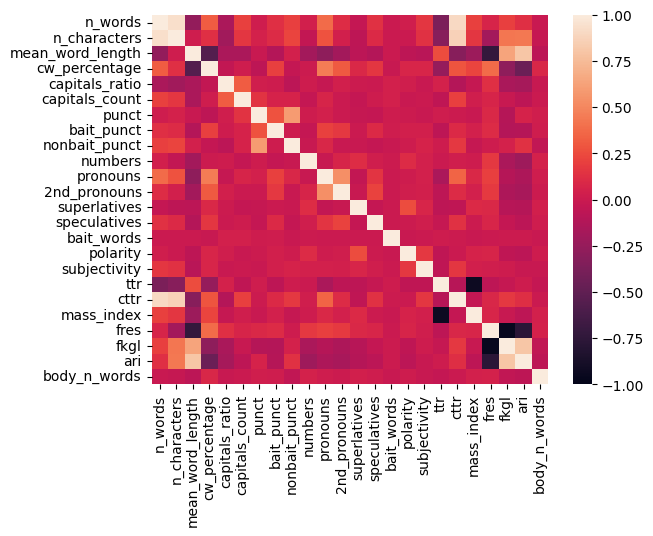

In [214]:
# check corelation
X = final_data.drop(['title', 'body', 'clickbait'], axis=1)
y = final_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1, annot_kws={'alpha': 0})

<Axes: >

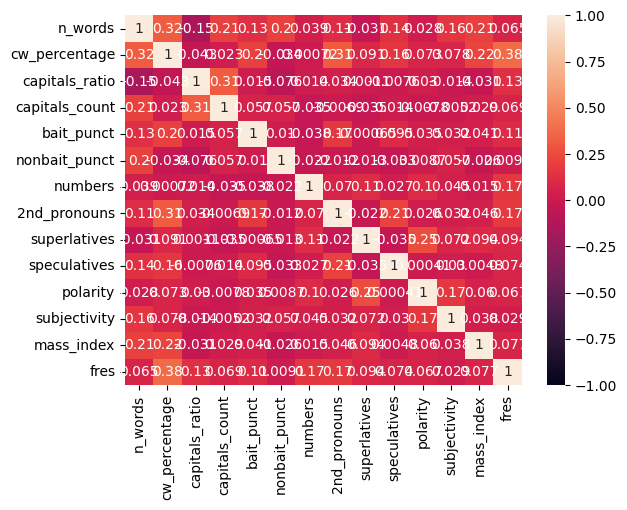

In [241]:
# dropping correlated columns:
# n_characters, mean_word_length, punctuation, ttr
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']
X = final_data[train_columns]
y = final_data['clickbait']

X_test = test_data[train_columns]
y_test = test_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [242]:
# split and prepare data
X_train = X
y_train = y

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [243]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.618236
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15828
Model:                          Logit   Df Residuals:                    15814
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1081
Time:                        15:09:26   Log-Likelihood:                -9785.4
converged:                       True   LL-Null:                       -10971.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.2273      0.021    -11.070      0.000      -0.267      -0.187
cw_percentage    

In [248]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.46 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2006
           1       0.64      0.64      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.65      0.64      0.64      3989
weighted avg       0.65      0.65      0.65      3989



Lets drop insignificant variables and fit the model again

In [263]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity']
X_train = X.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test2)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.618325
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15828
Model:                          Logit   Df Residuals:                    15817
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1079
Time:                        15:12:38   Log-Likelihood:                -9786.9
converged:                       True   LL-Null:                       -10971.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.2330      0.020    -11.777      0.000      -0.272      -0.194
cw_percentage    

In [264]:
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.46 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2006
           1       0.65      0.64      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.65      0.65      0.65      3989
weighted avg       0.65      0.65      0.65      3989



<!-- We got better accuracy, but it's impossible to build a good model based only of informativeness measures of title. Also, many of them are correlated, so its enough to choose only some of them (eg n_words, fkgl, cw_percentage). 

Conclusions from the model - headlines which are easier to read (fkgl), contain less words, but have higher common words percentage are more likely to be classified as clickbait.

 -->
Almost identical, but slightly better perormance.<br>
All coeficients correspond to the analysis.

For the sake of testing, lets put all the variables to random forest:

In [299]:
X_train = final_data.drop(['title', 'body', 'clickbait', 'body_n_words'], axis=1)
y_train = final_data['clickbait']

X_test = test_data.drop(['title', 'body', 'clickbait'], axis=1)
y_test = test_data['clickbait']

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2006
           1       0.66      0.63      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.66      0.65      0.65      3989
weighted avg       0.66      0.65      0.65      3989



lets add a little bit of fine tuning including dropping correlated columns, setting max depth to prevent overfitting

In [337]:
rf = RandomForestClassifier(n_estimators=120, max_depth=15)
rf.fit(X_train[train_columns], y_train)

threshold = 0.47
predicted_proba = rf.predict_proba(X_test[train_columns])
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2006
           1       0.68      0.67      0.67      1983

    accuracy                           0.68      3989
   macro avg       0.68      0.68      0.68      3989
weighted avg       0.68      0.68      0.68      3989



In [338]:
pd.DataFrame(data={'feature': rf.feature_names_in_, 'importance': rf.feature_importances_}, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
1,cw_percentage,0.165545
2,capitals_ratio,0.153074
13,fres,0.121995
0,n_words,0.092916
10,polarity,0.087973
11,subjectivity,0.084912
7,2nd_pronouns,0.077474
5,nonbait_punct,0.047321
12,mass_index,0.042527
6,numbers,0.034356


### Body analysis

#### Preprocessing

In [ ]:
raw_body_data = final_data.copy()
raw_body_test_data = test_data.copy()

In [ ]:
# apply metrics

# TRAIN
for name, function in tqdm(metrics_functions.items()):
    if name not in ["similarity"] :
        raw_body_data[f"body_{name}"] = raw_body_data['body'].apply(function)

name = 'similarity'
function = metrics_functions[name]
raw_body_data[f"body_{name}"] = raw_body_data.apply(lambda x: function(x['title'], x['body']), axis=1)

# TEST
for name, function in tqdm(metrics_functions.items()):
    if name not in ["similarity"] :
        raw_body_test_data[f"body_{name}"] = raw_body_test_data['body'].apply(function)

name = 'similarity'
function = metrics_functions[name]
raw_body_test_data[f"body_{name}"] = raw_body_test_data.apply(lambda x: function(x['title'], x['body']), axis=1)

raw_body_data.drop(raw_body_data[raw_body_data.isna().any(axis=1)].index, inplace=True)
raw_body_test_data.drop(raw_body_test_data[raw_body_test_data.isna().any(axis=1)].index, inplace=True)

In [82]:
raw_body_data.to_csv("../data/inf_measures_data/full_data.csv", index=False)
raw_body_test_data.to_csv("../data/inf_measures_data/full_test_data.csv", index=False)

In [11]:
raw_body_data = pd.read_csv("../data/inf_measures_data/full_data.csv")
raw_body_test_data = pd.read_csv("../data/inf_measures_data/full_test_data.csv")

In [14]:
body_columns = [col for col in raw_body_data.columns if col.startswith("body_")]

In [15]:
# changing count columns to ratio by dividing counts by either body_n_characters or body_n_words
# all titles are relatively short and we are curious if some phrase was used or not. however in article bodies we need to check the ratio, as the articles differ much in length

body_data = raw_body_data.copy()
body_test_data = raw_body_test_data.copy()

for count_col in body_columns[5:15]:
    if count_col == 'body_punct':
        # its already calculated as ratio
        continue

    print(f"processing {count_col}")

    # TRAIN
    if 'punct' in count_col:
        body_data[count_col] = body_data.apply(lambda x: x[count_col] / x['body_n_characters'], axis=1)
    else:
        body_data[count_col] = body_data.apply(lambda x: x[count_col] / x['body_n_words'], axis=1)

    # TEST
    if 'punct' in count_col:
        body_test_data[count_col] = body_test_data.apply(lambda x: x[count_col] / x['body_n_characters'], axis=1)
    else:
        body_test_data[count_col] = body_test_data.apply(lambda x: x[count_col] / x['body_n_words'], axis=1)
    

processing body_capitals_count
processing body_bait_punct
processing body_nonbait_punct
processing body_numbers
processing body_pronouns
processing body_2nd_pronouns
processing body_superlatives
processing body_speculatives
processing body_bait_words


#### Overview

array([[<Axes: title={'center': 'body_n_words'}>,
        <Axes: title={'center': 'body_n_characters'}>,
        <Axes: title={'center': 'body_mean_word_length'}>,
        <Axes: title={'center': 'body_cw_percentage'}>,
        <Axes: title={'center': 'body_capitals_ratio'}>],
       [<Axes: title={'center': 'body_capitals_count'}>,
        <Axes: title={'center': 'body_punct'}>,
        <Axes: title={'center': 'body_bait_punct'}>,
        <Axes: title={'center': 'body_nonbait_punct'}>,
        <Axes: title={'center': 'body_numbers'}>],
       [<Axes: title={'center': 'body_pronouns'}>,
        <Axes: title={'center': 'body_2nd_pronouns'}>,
        <Axes: title={'center': 'body_superlatives'}>,
        <Axes: title={'center': 'body_speculatives'}>,
        <Axes: title={'center': 'body_bait_words'}>],
       [<Axes: title={'center': 'body_polarity'}>,
        <Axes: title={'center': 'body_subjectivity'}>,
        <Axes: title={'center': 'body_ttr'}>,
        <Axes: title={'center': 'bo

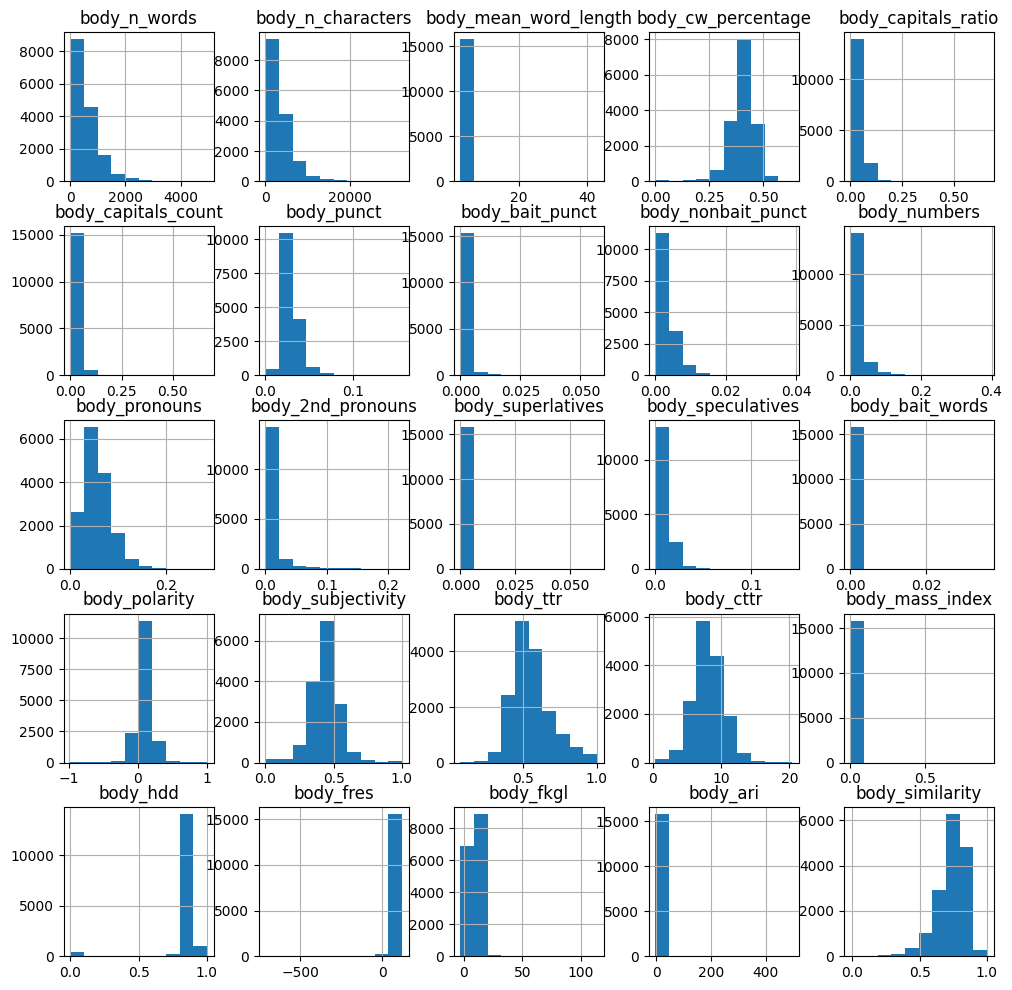

In [94]:
# check histograms
body_data[body_columns].hist(figsize=(12,12))

Now let's plot violinplots, as there we can find insights of the relationships of each variable with target var

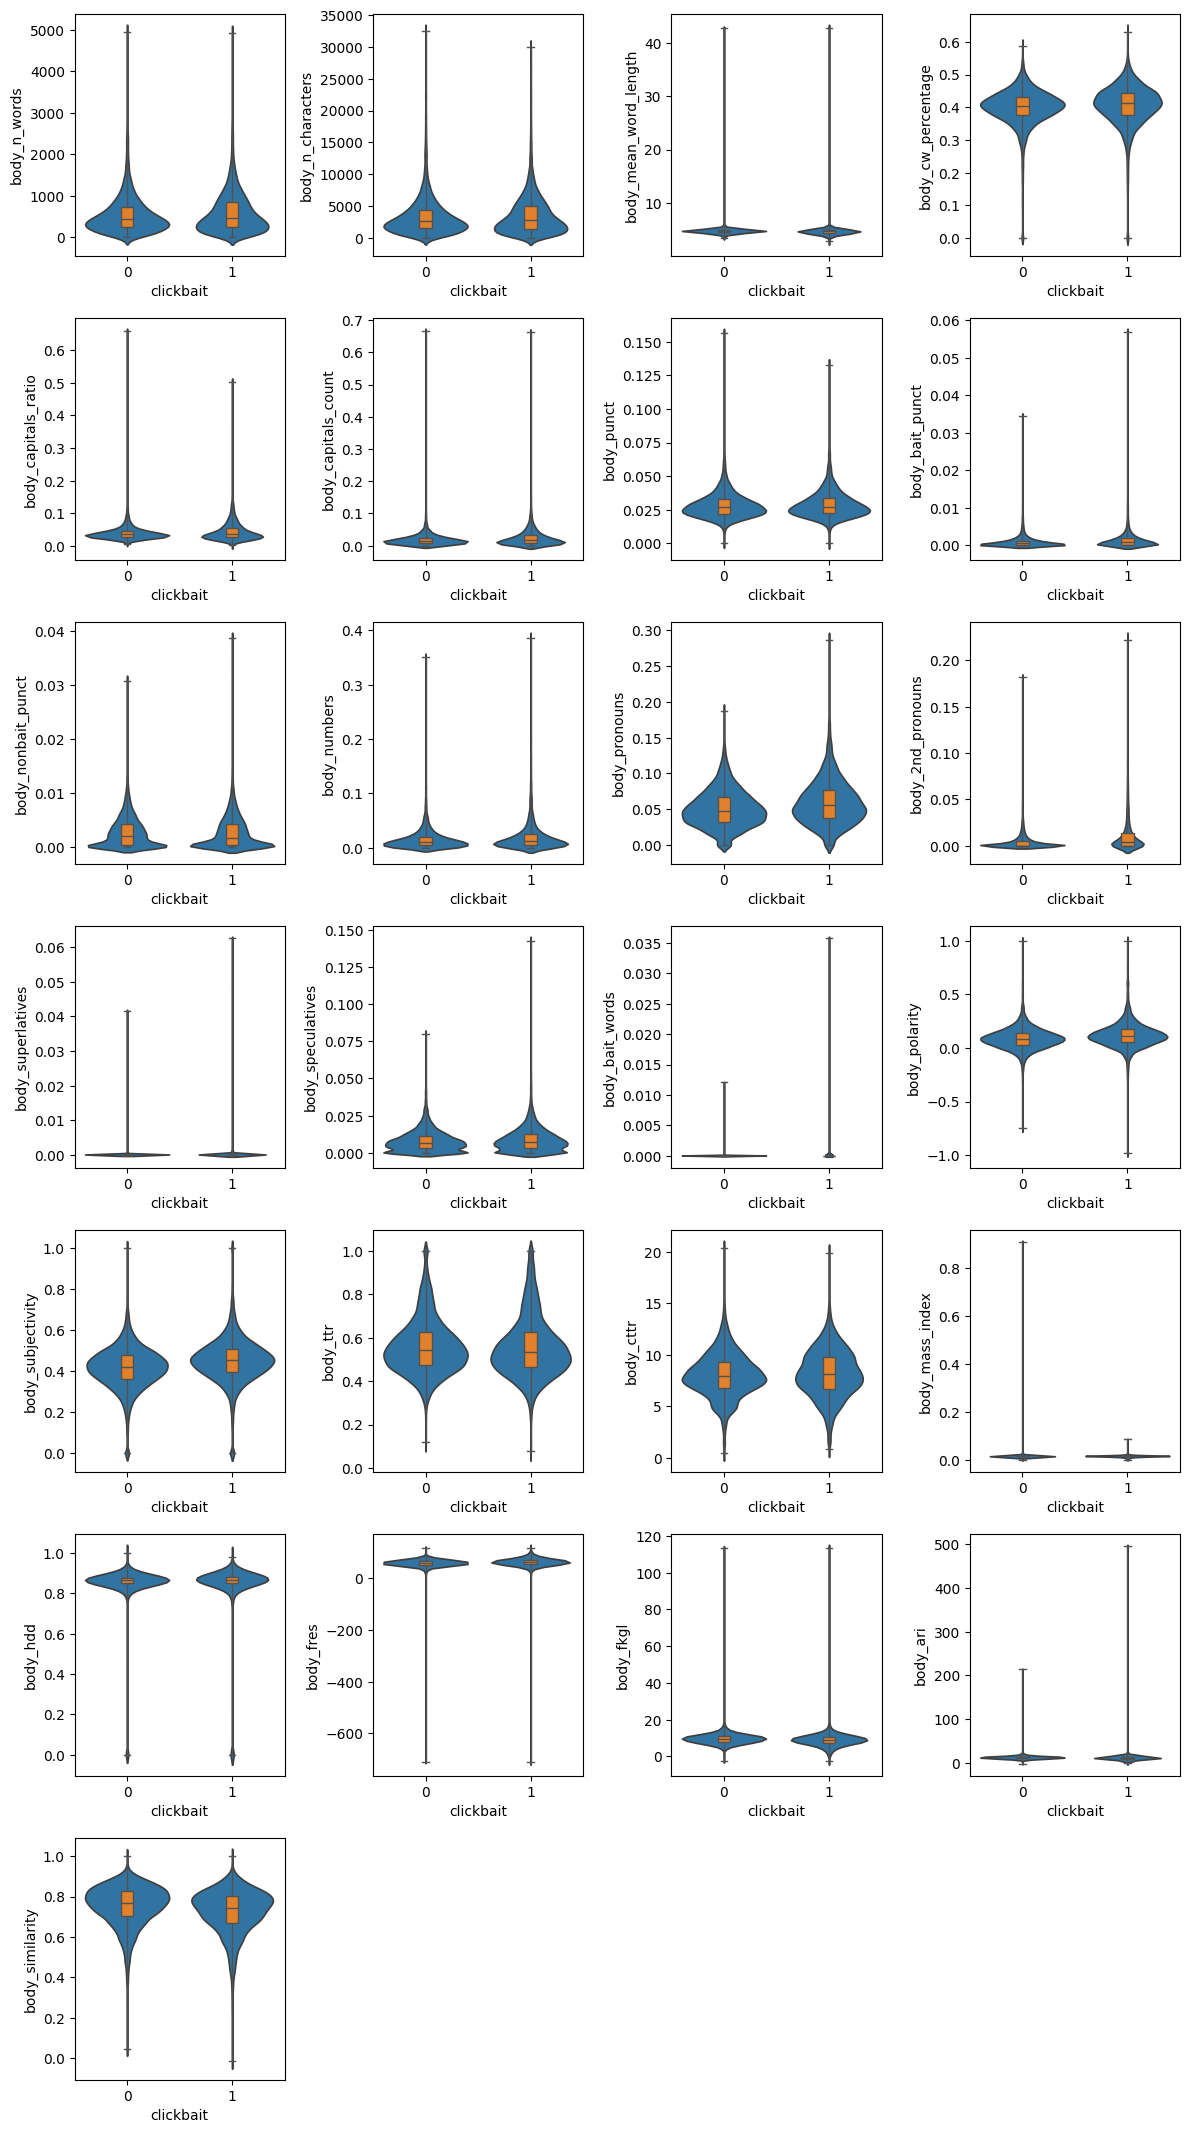

In [96]:
plt.figure(figsize=(12,24))
columns = body_columns
for i, col in enumerate(columns):
    plt.subplot(8, 4, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=body_data, inner=None)
    sns.boxplot(x='clickbait', y=col, data=body_data, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

Due to many outliers, its hard to see the differences. Lets analyze each metric alone and print some numerical metrics.

#### Analysis

##### Number of words 

                 mean     std    min    50%    max  ratio
-------------  ------  ------  -----  -----  -----  -------
non clickbait  569.54  534.2       1  430     4952
clickbait      612.39  563.04      2  462.5   4918  1.08


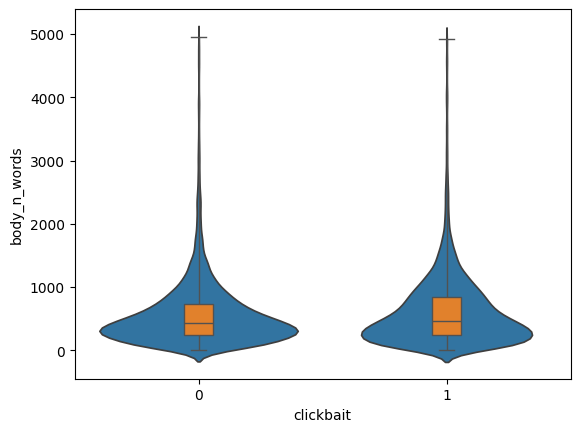

In [103]:
print_metrics(body_data, 'body_n_words')
plot_metrics(body_data, 'body_n_words')

In [ ]:
# we could reason that clickbaits are longer on the average, but probably its not a rule

##### Number of characters

                  mean      std    min     50%    max  ratio
-------------  -------  -------  -----  ------  -----  -------
non clickbait  3416.89  3165.04      4  2582.5  32428
clickbait      3636.12  3319.1      16  2751    29910  1.06


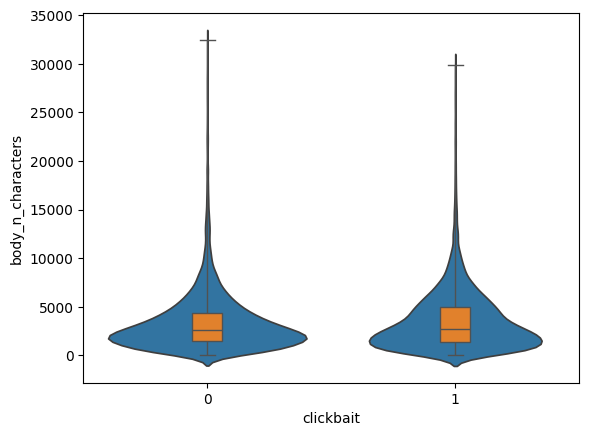

In [106]:
print_metrics(body_data, 'body_n_characters')
plot_metrics(body_data, 'body_n_characters')

In [ ]:
# charts identical as the word distributions

##### Mean word length

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    4.77   0.85   3.42   4.75  42.75
clickbait        4.74   1.84   2.78   4.65  42.75  0.99


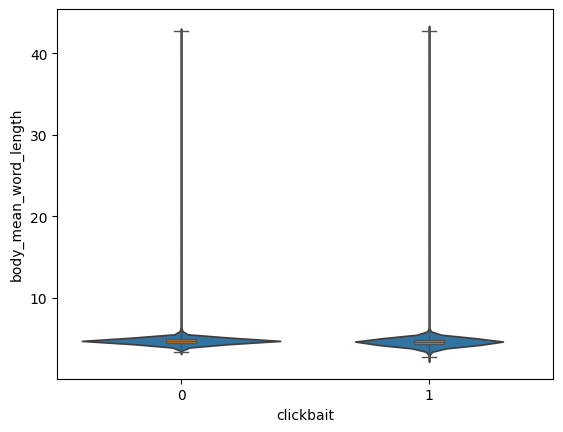

In [110]:
print_metrics(body_data, 'body_mean_word_length')
plot_metrics(body_data, 'body_mean_word_length')

In [111]:
# words are just a little bit shorter for clickbait articles

##### Common words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.4    0.057      0  0.405  0.588
clickbait       0.406  0.063      0  0.411  0.632  1.015


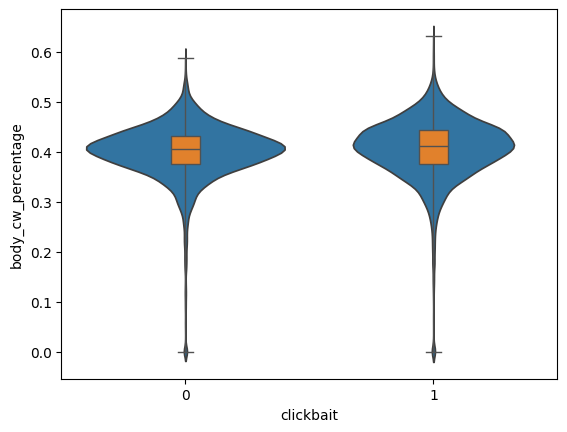

In [119]:
print_metrics(body_data, 'body_cw_percentage', round_val=3)
plot_metrics(body_data, 'body_cw_percentage')

In [ ]:
# slightly more common words for clickbait articles

##### Capital characters ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.04   0.023  0.007  0.035  0.659
clickbait       0.045  0.031  0.001  0.036  0.503  1.125


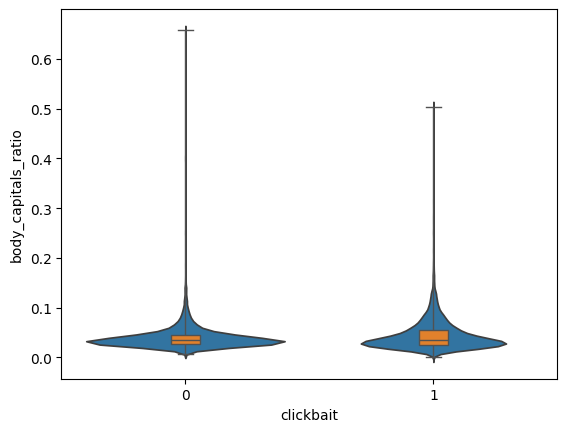

In [11]:
print_metrics(body_data, 'body_capitals_ratio', round_val=3)
plot_metrics(body_data, 'body_capitals_ratio')

In [ ]:
# the difference is visible, there are more capital letters in clickbait articles

##### Capital words ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.019  0.019      0  0.015  0.667
clickbait       0.025  0.028      0  0.017  0.662  1.29


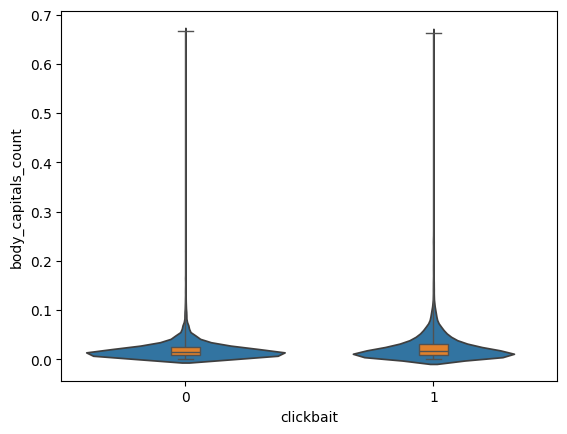

In [24]:
print_metrics(body_data, 'body_capitals_count', round_val=3)
plot_metrics(body_data, 'body_capitals_count')

In [ ]:
# little difference is visible on charts and stats with more full capital words in clickbait articles

##### Punctuation ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.028  0.01       0  0.027  0.156
clickbait       0.03   0.012      0  0.027  0.133  1.04


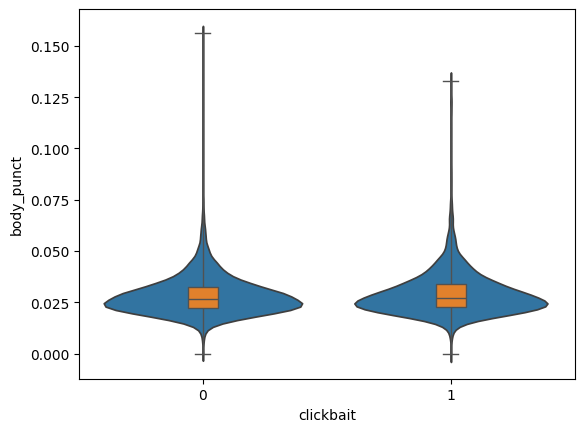

In [23]:
print_metrics(body_data, 'body_punct', round_val=3)
plot_metrics(body_data, 'body_punct')

In [ ]:
# almost no difference at all

##### Bait punctuation ratio

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.001   0.0021      0  0.0005  0.0345
clickbait      0.0015  0.0028      0  0.0008  0.0568  1.52


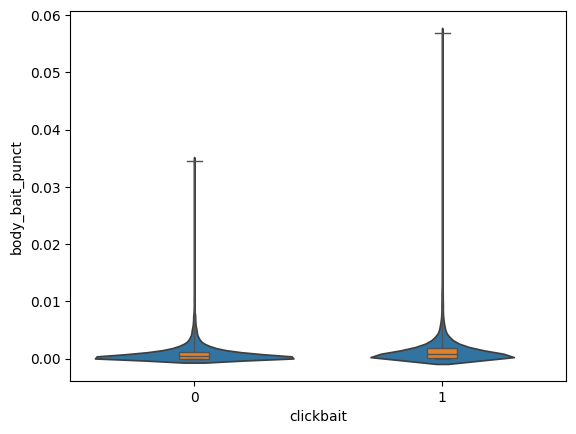

In [22]:
print_metrics(body_data, 'body_bait_punct', round_val=4)
plot_metrics(body_data, 'body_bait_punct')

In [ ]:
# bait punctuation is used more in clickbait articles :D

##### Non bait punctuation ratio

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.0028  0.0029      0  0.0021  0.0308
clickbait      0.0028  0.0032      0  0.0018  0.0387  1.0


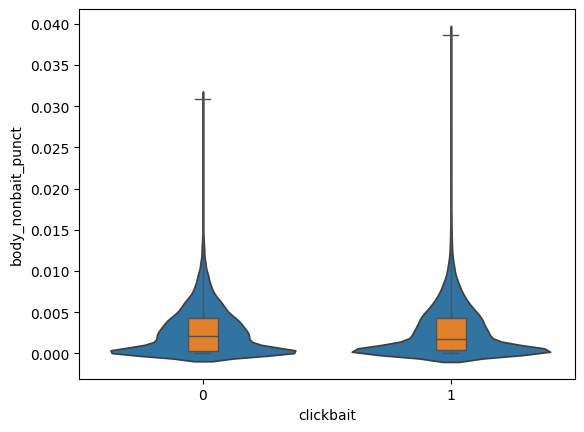

In [25]:
print_metrics(body_data, 'body_nonbait_punct', round_val=4)
plot_metrics(body_data, 'body_nonbait_punct')

In [ ]:
# however, here there are no differences in means and medians in opposition to what happens in headlines

##### Numbers ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.016  0.02       0  0.011  0.351
clickbait       0.02   0.027      0  0.012  0.387  1.27


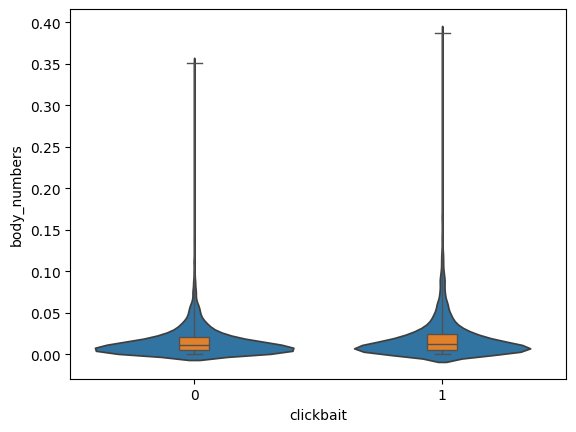

In [29]:
print_metrics(body_data, 'body_numbers', round_val=3)
plot_metrics(body_data, 'body_numbers')

In [ ]:
# we can see that clickbaits use more numbers. again, the difference is not that clear as in headlines

##### Pronouns ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.051  0.026      0  0.048  0.188
clickbait       0.06   0.032      0  0.055  0.286  1.17


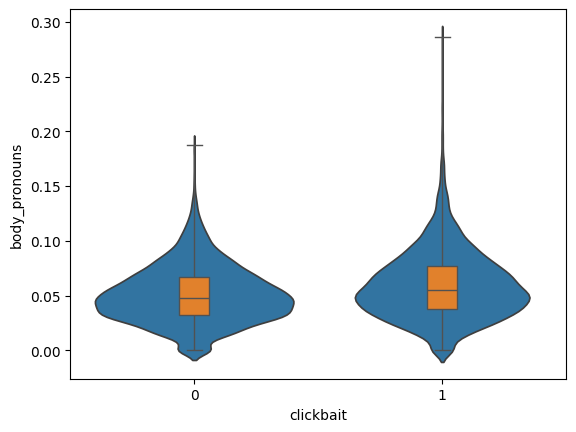

In [28]:
print_metrics(body_data, 'body_pronouns', round_val=3)
plot_metrics(body_data, 'body_pronouns')

In [ ]:
# slightly bigger usage for clickbaits

##### 2nd person pronouns ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.004  0.009      0  0      0.182
clickbait       0.013  0.023      0  0.004  0.222  2.91


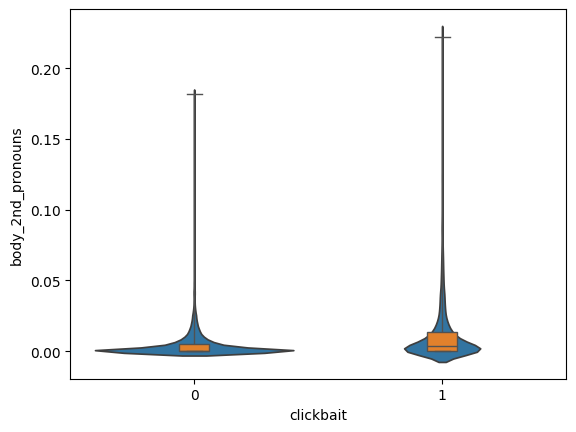

In [31]:
print_metrics(body_data, 'body_2nd_pronouns', round_val=3)
plot_metrics(body_data, 'body_2nd_pronouns')

In [ ]:
# Huge difference in this metric, almost 3 times more 2nd person pronouns appear in articles with clickbaits headlines than in non-clickbait ones.

##### Superlatives ratio

                  mean      std    min    50%      max  ratio
-------------  -------  -------  -----  -----  -------  -------
non clickbait  0.00011  0.00078      0  2e-05  0.04167
clickbait      0.00016  0.00144      0  3e-05  0.0625   1.48


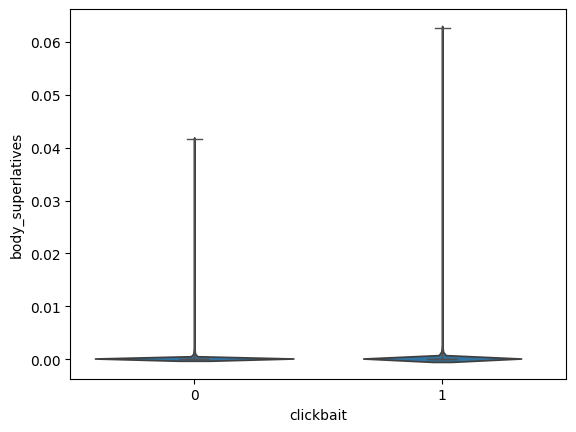

In [38]:
print_metrics(body_data, 'body_superlatives', round_val=5)
plot_metrics(body_data, 'body_superlatives')

In [ ]:
# Superlatives are such rare phenomenon that it is not worth analyzing

##### Speculatives

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.008   0.0073      0  0.0067  0.08
clickbait      0.0089  0.0083      0  0.0075  0.1429  1.11


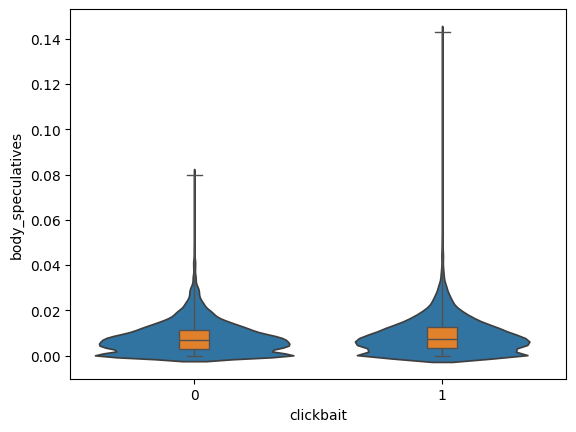

In [39]:
print_metrics(body_data, 'body_speculatives', round_val=4)
plot_metrics(body_data, 'body_speculatives')

In [40]:
# just a little bit more speculatives used in body

##### Bait words ratio

In [ ]:
# TODO 

##### Similarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.75   0.1    0.05   0.77      1
clickbait        0.72   0.11  -0.01   0.74      1  0.96


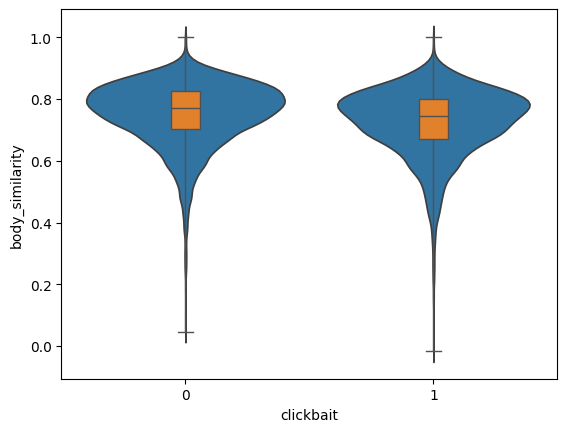

In [43]:
print_metrics(body_data, 'body_similarity', round_val=2)
plot_metrics(body_data, 'body_similarity')

In [ ]:
# results make sense as the similarity between text and title is bigger for non-clickbait articles, still the difference is really small

##### Polarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.09   0.1   -0.75   0.09      1
clickbait        0.12   0.12  -0.98   0.11      1  1.33


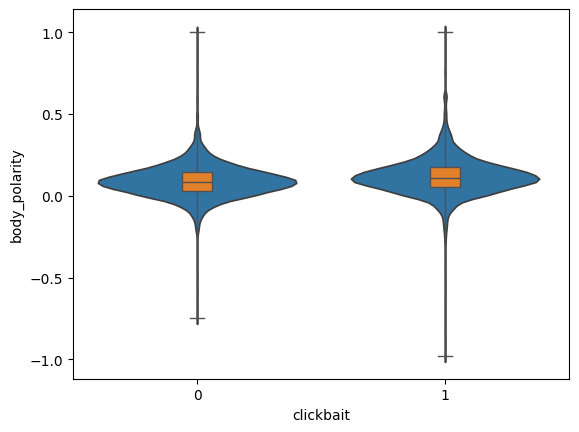

In [44]:
print_metrics(body_data, 'body_polarity', round_val=2)
plot_metrics(body_data, 'body_polarity')

In [ ]:
# yet again, the polarity is more varied and little bit more positive

##### Subjectivity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.42   0.1       0   0.42      1
clickbait        0.45   0.11      0   0.45      1  1.08


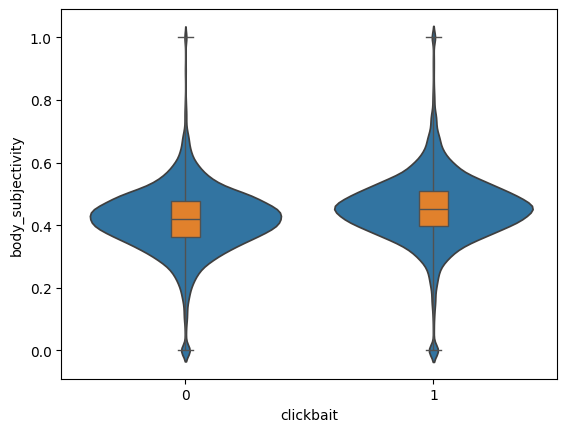

In [45]:
print_metrics(body_data, 'body_subjectivity', round_val=2)
plot_metrics(body_data, 'body_subjectivity')

In [ ]:
# clickbaits articles are more subjective

##### Type token ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.56   0.13   0.12   0.54      1
clickbait        0.56   0.14   0.08   0.53      1  1.0


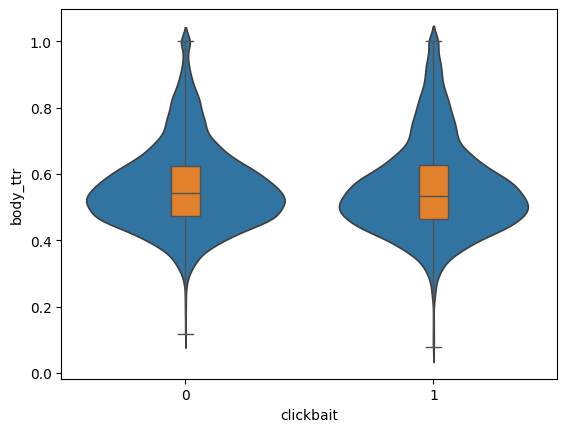

In [46]:
print_metrics(body_data, 'body_ttr', round_val=2)
plot_metrics(body_data, 'body_ttr')

In [ ]:
# the lexical diversity is almost the same with a nod to non-clickbaits articles

##### CTTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    8.05   2.13   0.41   7.93  20.36
clickbait        8.18   2.35   0.85   8.11  19.93  1.02


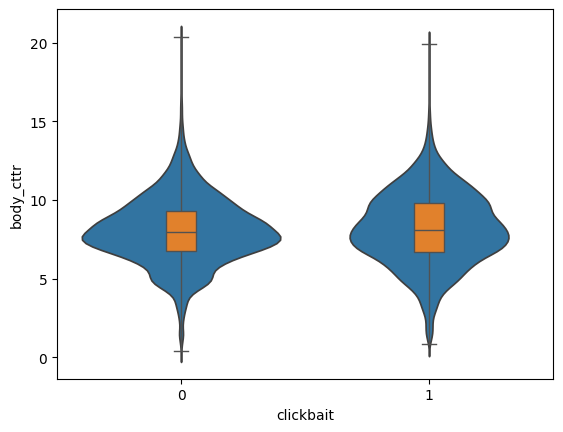

In [47]:
print_metrics(body_data, 'body_cttr', round_val=2)
plot_metrics(body_data, 'body_cttr')

In [ ]:
# clickbait articles are slightly more diversed, but again the difference is really small

##### Maas index

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.016  0.011      0  0.016  0.91
clickbait       0.016  0.005      0  0.016  0.086  0.99


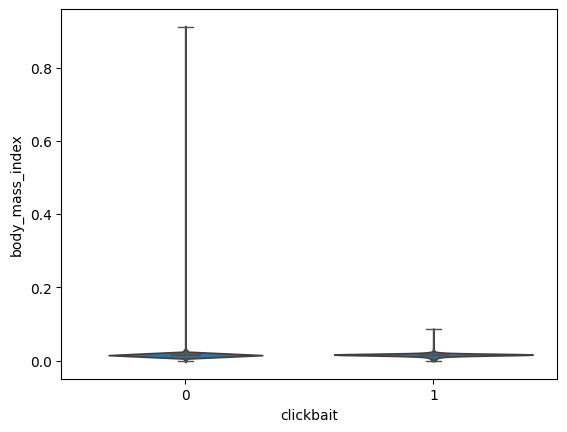

In [49]:
print_metrics(body_data, 'body_mass_index', round_val=3)
plot_metrics(body_data, 'body_mass_index')

In [ ]:
# no idea why it is so small. still, no differences at all

##### HDD

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.85   0.12      0   0.86   1
clickbait        0.84   0.15      0   0.87   0.98  0.99


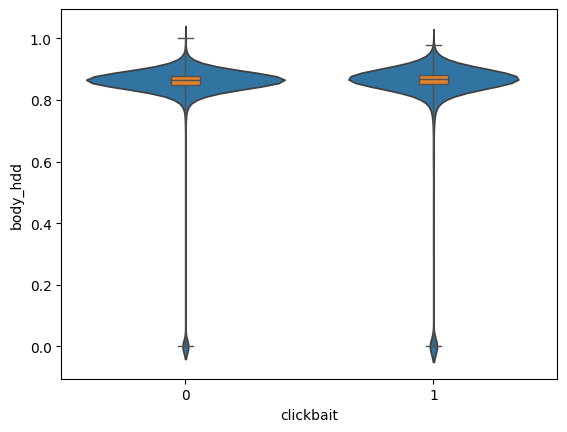

In [50]:
print_metrics(body_data, 'body_hdd', round_val=2)
plot_metrics(body_data, 'body_hdd')

In [ ]:
# all the metrics, including HDD, show that there are no differences in lexical diversity between texts with clickbait headlines and text with nonclickbait headlines

##### FRES

                 mean    std      min    50%     max  ratio
-------------  ------  -----  -------  -----  ------  -------
non clickbait   60.24  18.36  -710.91  60.8   118.18
clickbait       62.4   35.68  -710.91  63.83  119.19  1.04


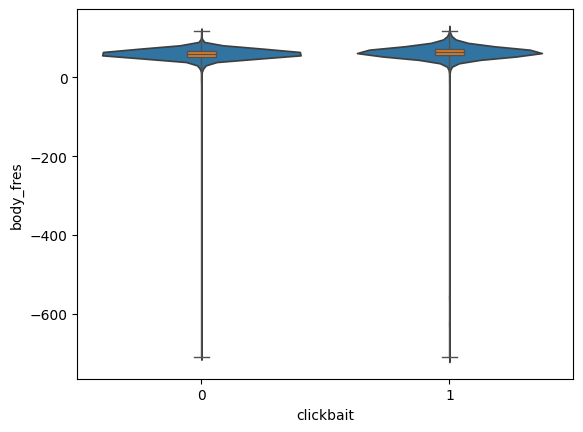

In [51]:
print_metrics(body_data, 'body_fres', round_val=2)
plot_metrics(body_data, 'body_fres')

In [ ]:
# clickbaits just a little bit easier to read. there are some outliers because of the fact that some articles are super short. 

##### FKGL

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    9.79   3.24   -2.3    9.7  113.4
clickbait        9.28   5.44   -2.7    9.1  113.4  0.95


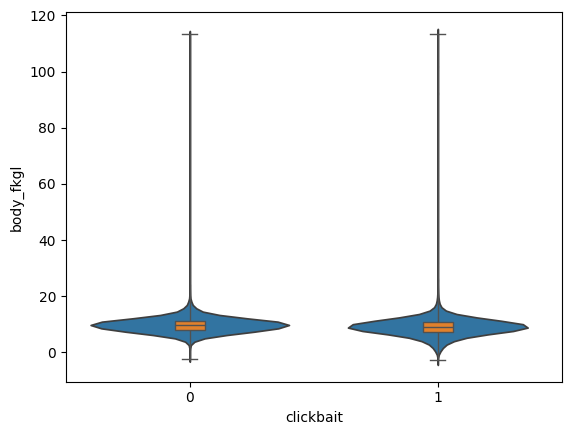

In [52]:
print_metrics(body_data, 'body_fkgl', round_val=2)
plot_metrics(body_data, 'body_fkgl')

In [ ]:
# again, clickbaits just a little bit easier to read.

##### ARI

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   12.46   5.17   -2.2   12.2  213.7
clickbait       12.13  11.39   -0.8   11.5  495.6  0.97


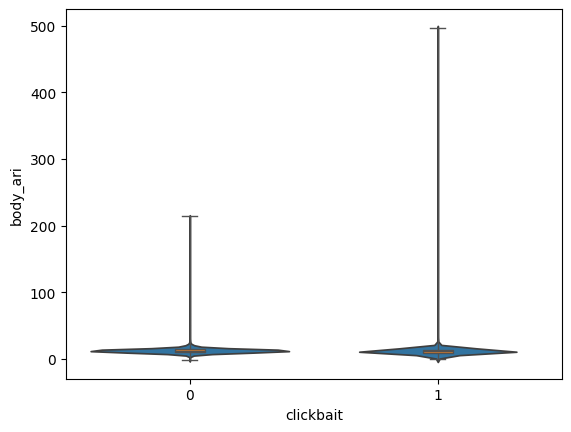

In [54]:
print_metrics(body_data, 'body_ari', round_val=2)
plot_metrics(body_data, 'body_ari')

In [ ]:
# once again, clickbaits slightly easier to read. each text difficulty measure output showed the same, so we can assume that it is true and clickbait articles on average are easier to read.

#### Summary

Relationships between measures and clickbaits are similar as in the headlines, but the differences are weaker and less visible than in the headlines. 

#### Fitting models

<Axes: >

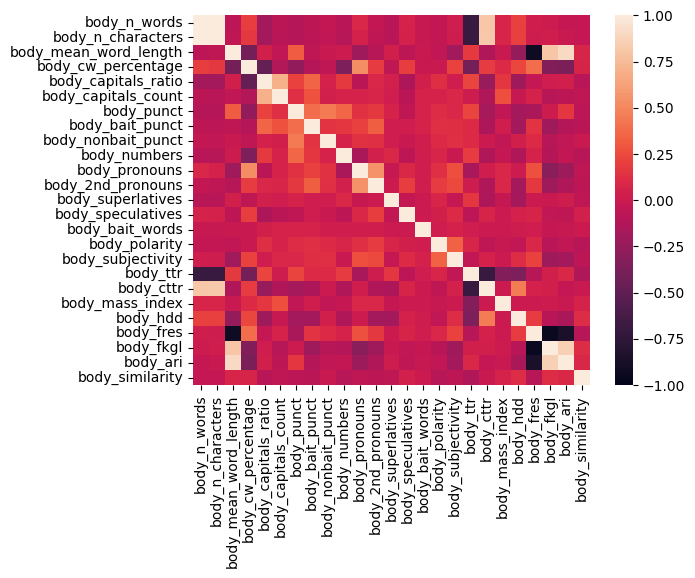

In [57]:
# check corelation
X = body_data[body_columns]
y = body_data['clickbait']

sns.heatmap(X.corr(), annot=False, vmax=1, vmin=-1)

<Axes: >

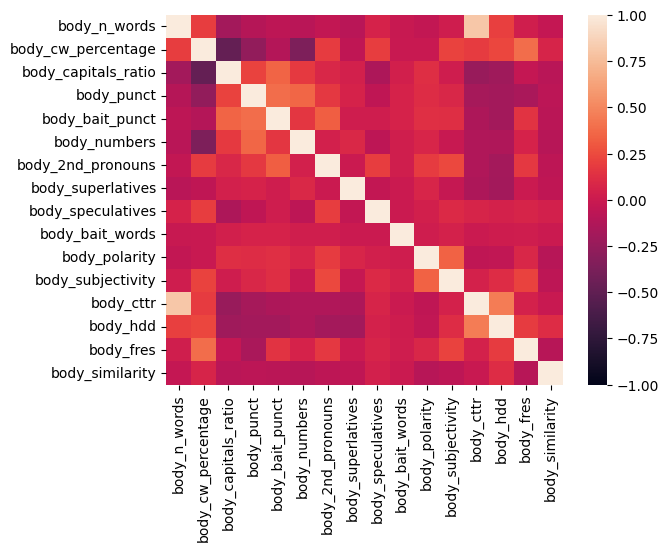

In [16]:
# dropping correlated columns
body_cols_to_drop = ['body_n_characters', 'body_mean_word_length', 'body_capitals_count', 'body_nonbait_punct', 'body_pronouns', 'body_ttr', 'body_mass_index', 'body_fkgl', 'body_ari']
body_columns_dropped = [col for col in body_columns if col not in body_cols_to_drop]

X = body_data[body_columns_dropped]
y = body_data['clickbait']

sns.heatmap(X.corr(), annot=False, vmax=1, vmin=-1)

In [17]:
# from title analysis
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']

X = body_data[train_columns + body_columns_dropped]
y = body_data['clickbait']

X_test = body_test_data[train_columns + body_columns_dropped]
y_test = body_test_data['clickbait']

In [18]:
X_train = X
y_train = y

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [88]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.592755
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15823
Model:                          Logit   Df Residuals:                    15793
Method:                           MLE   Df Model:                           29
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                  0.1448
Time:                        21:37:49   Log-Likelihood:                -9379.2
converged:                       True   LL-Null:                       -10968.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
n_words                -0.1559      0.022     -6.982      0.000      -0.200      -0.112
cw

In [92]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.44 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2006
           1       0.68      0.69      0.69      1982

    accuracy                           0.69      3988
   macro avg       0.69      0.69      0.69      3988
weighted avg       0.69      0.69      0.69      3988



There is also big corelation between only n_words and ttr, so lets drop one and fit a model again

In [98]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity', 'mass_index', 'body_speculatives', 'body_superlatives', 'body_hdd', 'body_bait_words']

X_train = X.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test2)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.592974
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15823
Model:                          Logit   Df Residuals:                    15801
Method:                           MLE   Df Model:                           21
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                  0.1445
Time:                        21:42:29   Log-Likelihood:                -9382.6
converged:                       True   LL-Null:                       -10968.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
n_words                -0.1531      0.021     -7.217      0.000      -0.195      -0.112
cw

In [99]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.44 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2006
           1       0.69      0.69      0.69      1982

    accuracy                           0.69      3988
   macro avg       0.69      0.69      0.69      3988
weighted avg       0.69      0.69      0.69      3988



Out metrics did not get better, but atleast our model is smaller.

Lets try to fit random forest with all the variables:

In [20]:
# from title analysis
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']

X_train = body_data[train_columns + body_columns_dropped]
y_train = body_data['clickbait']

X_test = body_test_data[train_columns + body_columns_dropped]
y_test = body_test_data['clickbait']

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      2006
           1       0.73      0.72      0.73      1982

    accuracy                           0.73      3988
   macro avg       0.73      0.73      0.73      3988
weighted avg       0.73      0.73      0.73      3988



And with little bit of manual fine tuning:

In [110]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity', 'mass_index', 'body_speculatives', 'body_superlatives', 'body_hdd', 'body_bait_words']

X_train2 = X_train.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

rf = RandomForestClassifier(n_estimators=120, max_depth=15)
rf.fit(X_train2, y_train)

threshold = 0.48
predicted_proba = rf.predict_proba(X_test2)
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2006
           1       0.73      0.73      0.73      1982

    accuracy                           0.73      3988
   macro avg       0.73      0.73      0.73      3988
weighted avg       0.73      0.73      0.73      3988



Grid search fine tuning

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features':  ['sqrt', 'log2']
}

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train2, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=120),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
best_params

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 200}

In [126]:
threshold = 0.48
predicted_proba = best_rf.predict_proba(X_test2)
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2006
           1       0.72      0.76      0.74      1982

    accuracy                           0.74      3988
   macro avg       0.74      0.74      0.74      3988
weighted avg       0.74      0.74      0.74      3988



In [129]:
pd.DataFrame(data={'feature': best_rf.feature_names_in_, 'importance': best_rf.feature_importances_}, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
12,body_capitals_ratio,0.085723
1,cw_percentage,0.072976
16,body_2nd_pronouns,0.064433
21,body_similarity,0.059708
18,body_subjectivity,0.057953
2,capitals_ratio,0.055062
19,body_cttr,0.054916
13,body_punct,0.054829
20,body_fres,0.054061
10,body_n_words,0.053644


Including measures of the article body helped us achieve a lot better model

0.74 f_score and accuracy vs  0.68 f_score and accuracy for titles only

## Our measure

In [ ]:
"""
eye catchingness
special punctuation - yes / no
only capital letters word
sqrt capitals
number 

curiosity generating techniques
2nd person pronoun - yes / no
superlatives - yes / no
bait vocabulary - yes / no

sqrt common words 

average of usages 

sentiment
sqrt() for each and then multiply
"""

'\neye catchingness\nspecial punctuation - yes / no\nonly capital letters word\nsqrt capitals\nnumber \n\ncuriosity generating techniques\n2nd person pronoun - yes / no\nsuperlatives - yes / no\nbait vocabulary - yes / no\n\nsqrt common words \n\naverage of usages \n\n\n\nsimilarity\n\nsentiment\nsqrt() for each and then multiply\n'

In [41]:
def cut_value(value):
    if value > 1:
        return 1
    elif value < 0:
        return 0
    return value

In [ ]:
def baitness_measure(text, debug=False):

    # eye catchingness
    punct_count = clickbait_punctuation_count(text)
    capitals_ratio = capital_letters_ratio(text) * 3
    capitals_count = capital_words_count(text)
    number_count = numbers_count(text)

    eye_catch_list = [punct_count, capitals_ratio, capitals_count, number_count]
    eye_catch = cut_value(np.mean(eye_catch_list))
    if debug:
        print(eye_catch_list)
    
    # content curiosity
    pronouns_2_count = pronouns_2nd_person_count(text)
    super_count = superlatives_ratio(text) * 2
    spec_count = speculatives_count(text)
    bait_words = baiting_words_count(text)

    curiosity_list = [pronouns_2_count, super_count, spec_count, bait_words]
    curiosity = np.sqrt(cut_value(np.mean(curiosity_list)))
    if debug:
        print(curiosity_list)

    # sentiment - measures high polarity and high subjectivity
    sentiment = math.sqrt(abs(polarity_score(text)) * subjectivity_score(text))

    # difficulty of reading - reading ease score and common words ratio
    fres = cut_value(flesch_reading_ease_score(text) / 100)
    cw_ratio = cut_value(common_words_ratio(text) * 1.5)
    ease_of_text = np.mean([fres, cw_ratio])

    metric_list = [eye_catch, sentiment, ease_of_text, curiosity]
    measure = np.mean(metric_list)
    if debug:
        print(metric_list)
    
    return measure

In [128]:
baitness_measure(sample_text[:66], debug=True)

[1, 0.4545454545454546, 0, 1]
[1, 0.6666666666666666, 0, 0]
[0.6136363636363636, 0.35355339059327373, 0.6165772727272727, 0.6454972243679028]


0.5573160628312032

In [129]:
baitness_measure("Daniel Kaluuya: 'In Britain I’m too black, in America I'm not black enough'", debug=True)

[0, 0.28, 0, 0]
[0, 0.0, 0, 0]
[0.07, 0.11249142628509215, 0.7606, 0.0]


0.23577285657127306

In [ ]:
custom_data = data.copy()
custom_data['measure'] = custom_data['title'].apply(baitness_measure)

In [133]:
custom_data['measure_sqrt'] = custom_data['measure'].apply(math.sqrt)

In [136]:
print_metrics(custom_data, column="measure")

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.24   0.11   0      0.22   0.83
clickbait        0.31   0.14   0.01   0.29   0.83  1.31


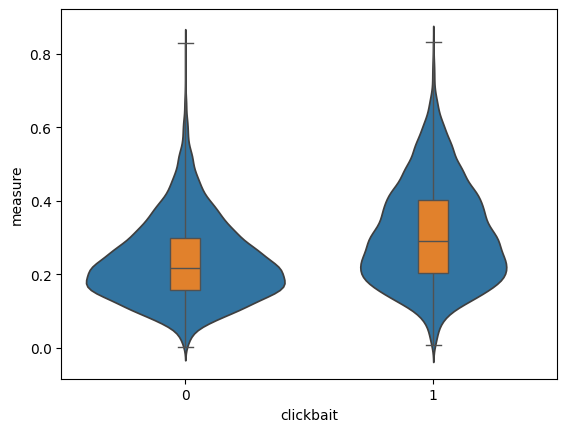

In [132]:
plot_metrics(custom_data, column="measure")

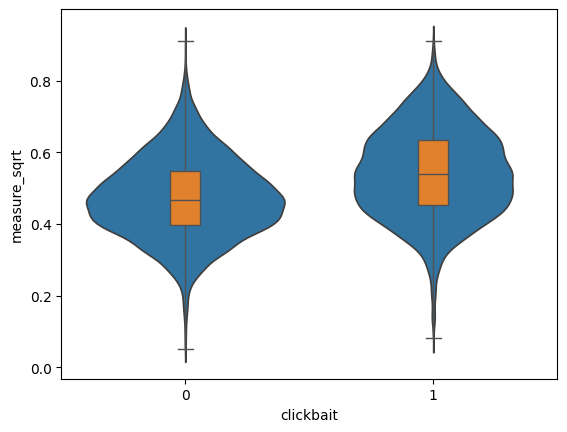

In [150]:
plot_metrics(custom_data, column="measure_sqrt")

In [137]:
custom_data[custom_data['measure'] > 0.6].drop(['body'], axis=1)[custom_data['clickbait'] == 0]

/tmp/ipykernel_1113/3570760281.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_data[custom_data['measure'] > 0.6].drop(['body'], axis=1)[custom_data['clickbait'] == 0]


,title,clickbait,measure,measure_sqrt
9691,The 20 best food books of 2016,0,0.623529,0.789638
9086,The 5 Best ABC Song Remixes,0,0.642606,0.801627
2473,"Hannity at CPAC: For Trump to Be Successful, He Needs Your Help Insider",0,0.604946,0.777783
6669,"J.T. Barrett Announces He Will Return to OSU in 2017: Latest Details, Reaction",0,0.704349,0.839255
1668,Vote: Who is the NBA's best point guard?,0,0.657457,0.810837
6269,23 Songs to Help You Forget About the Cold Weather,0,0.601362,0.775475
63,"It’s Time To Talk About ""One Tree Hill"" And The Worst Character On The Show",0,0.623923,0.789888
868,"Top stories Top stories Theresa May delays triggering Article 50 'Politics is not a game': May attacks Sturgeon over referendum call Trump doesn't believe Obama wiretapped him 'personally' Turkish president claims Germany ‘mercilessly supports terrorism' Subscribe to the Daily Edition, our newspaper for your tablet Amazon faces 'death spiral of drought and deforestation' Female Iraqi MP proposes legislation to encourage polygamy Snoop Dogg pulls gun on Donald Trump in new music video Law to fine men $100 for masturbating as 'act against an unborn child' Racism row over viral BBC interview as viewers assume mum is nanny talking points Siobhan Fenton The decriminalisation of abortion in England and Wales is a slap in the face for Northern Ireland John Rentoul Only the EU can stop Brexit now Most popular Greece offers ancient wonders in exchange for Elgin Marbles More than 90% of world's coral reefs will die by 2050 This is what will happen to the pound once Article 50 is triggered Sean O'Grady Why the Brexit Bill has to go through without amendments Andrew Buncombe Never mind the Russia links - there's a quicker way to get rid of Trump Man proposes to girlfriend through love letters with hidden message international Turkey vows retaliation against the Netherlands as crisis escalates Japan ‘to send largest warship to South China Sea’ in show of force Rachel Maddow becomes most-watched news show among anti-Trump viewers Suicide bomber, soldier, prison guard: Horrors of life for children in Syria laid bare Long reads Will the real outsider please stand up. I tip my hat to you Millennials and boomers don't have a gripe with each other What does it mean to be human? Celebrating real life female heroes through comic books Developing stories Trump's former campaign head accused of playing part in Ukraine deaths Everything you need to know once the Brexit process is triggered Iraqi troops face ‘house by house’ fight in final push against Isis Westminster should not deny Scotland a second referendum Josie Cox The data is misleading on diversity in British boardrooms Latest video Five things you need to know about the Hindu festival of Holi Woman shouts 'not today motherf***er' when fighting off 'sex attacker' New York baby sees father for first time with new glasses Heartbreaking video shows baby monkey crying over its dead mother Theresa May accuses SNP of playing a 'game' with second referendum Why the EU's Article 50 process is deliberately vague Nicola Sturgeon announces second Scottish referendum Nicola Sturgeon's Scottish independence referendum speech in full sport Kimmich frustrated at lack of Bayern playing time How Chris Woakes became England's unlikely star in West Indies tour Voices Sean O’Grady Major’s opinion on Brexit deserves to be listened to Will Gore Erdogan's tension with the Dutch Government suits everyone politically culture Kernels podcast: Bob Odenkirk talks the osmosis of comedy and drama Ed Sheeran domination of Singles Chart is 'one-off', OCC boss insists The Walking Dead season 7 episode 13 was a sequel-of-sorts UK needs museum on empire's 'divide and rule' of India, says author lifestyle Model born with ‘Cat Eye Syndrome’ stars in inspirational photoshoot Great British Bake Off winner creates world’s largest Jaffa Cake Accessible travel: Nine adventure holidays to do from a wheelchair Six of the best ways to update you

In [138]:
custom_data[custom_data['measure'] < 0.4].drop(['body'], axis=1)[custom_data['clickbait'] == 1]

/tmp/ipykernel_1113/2202612294.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_data[custom_data['measure'] < 0.4].drop(['body'], axis=1)[custom_data['clickbait'] == 1]


,title,clickbait,measure,measure_sqrt
14645,ADPVoice: How Does Your Organization Stack Up In Health Benefits Spending?,1,0.373013,0.610748
19461,Nightly News Why Confusing Food Labels Could Soon Be a Thing of the Past,1,0.398662,0.631397
11798,Report: Pornography Use Tied to Relationship Dissatisfaction,1,0.045536,0.213391
10336,Politico Scoop: Eric Trump Killed Two Deer,1,0.143437,0.378731
12167,The average wage for almost every job in America - Business Insider,1,0.177805,0.421669
...,...,...,...,...
11386,This viral photo of lemons could save your life,1,0.363491,0.602902
16894,A key way millennial homeowners differ from other generations,1,0.142446,0.377420
11307,DNC Deputy Chair Ellison: Obama Was Responsible for Some of the Party’s Failures In 2016,1,0.393708,0.627461
11991,Eight years that were way worse than 2016 The list,1,0.392474,0.626478


In [ ]:
threshold = 0.5

preds = (custom_data['measure_sqrt'].to_numpy() >= threshold).astype('int')

print(classification_report(custom_data['clickbait'], preds))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      7977
           1       0.61      0.61      0.61      7976

    accuracy                           0.61     15953
   macro avg       0.61      0.61      0.61     15953
weighted avg       0.61      0.61      0.61     15953



In [191]:
huge_data_raw = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [197]:
cols_huge_drop = list(huge_data_raw.columns[4:])
huge_data_full = huge_data_raw.drop(cols_huge_drop, axis=1)
huge_data = huge_data_full[huge_data_full['set']!=3].copy()

In [198]:
huge_data['measure'] = huge_data['title'].apply(baitness_measure)

In [177]:
huge_data['measure_sqrt'] = huge_data['measure'].apply(math.sqrt)

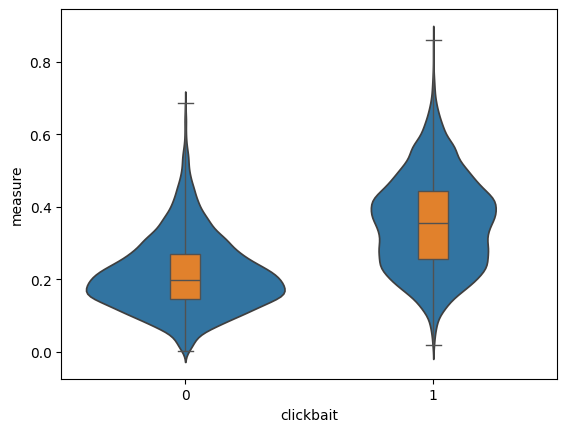

In [199]:
plot_metrics(huge_data, 'measure')

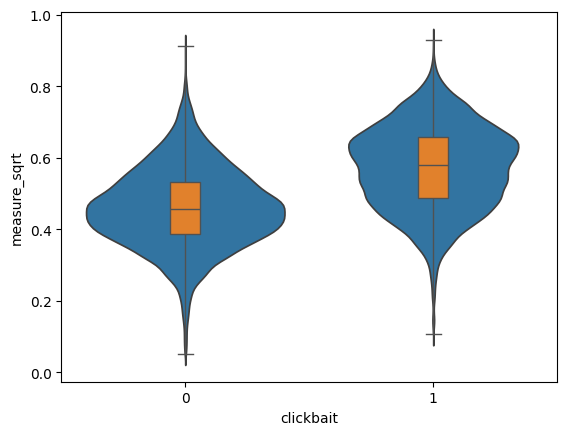

In [189]:
plot_metrics(huge_data, 'measure_sqrt')

In [204]:
threshold = 0.25

preds = (huge_data['measure'].to_numpy() >= threshold).astype('int')

print(classification_report(huge_data['clickbait'], preds))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     10645
           1       0.77      0.77      0.77     13806

    accuracy                           0.74     24451
   macro avg       0.73      0.73      0.73     24451
weighted avg       0.74      0.74      0.74     24451

